In [1]:
import argparse
import warnings

import numpy as np
import pandas
from sklearn.model_selection import train_test_split

import time
import seaborn as sns
import joblib
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_importance

warnings.filterwarnings("ignore")

In [2]:
# loss function
def handleZero(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1. / (y[ind])
    return w


def basicRmspe(y, y_hat):
    one_over_y = handleZero(y)
    s1 = one_over_y * (y - y_hat)
    s2 = np.mean(s1 ** 2)
    result = np.sqrt(s2)
    return result


def rmspe(y_hat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    y_hat = np.exp(y_hat) - 1
    result = basicRmspe(y, y_hat)
    return "rmspe", result

In [3]:
# normalize and one-hot code
def preprocess(x_train):
    one_hot_code_features = ["DayOfWeek", "StateHoliday", "StoreType", "Assortment",
                             "Year", "Month", "Day", "Promo2SinceWeek",
                             "Promo2SinceYear"]
    x_train = pandas.get_dummies(x_train, columns=one_hot_code_features)
    x_train["CompetitionDistance"] = (x_train["CompetitionDistance"] - x_train["CompetitionDistance"].min()) / (
            x_train["CompetitionDistance"].max() - x_train["CompetitionDistance"].min())
    return x_train

In [4]:
# normalize data
def preprocessNormalize(x_train):
    x_train["CompetitionDistance"] = (x_train["CompetitionDistance"] - x_train["CompetitionDistance"].min()) / (
            x_train["CompetitionDistance"].max() - x_train["CompetitionDistance"].min())

    return x_train

In [5]:
def linearRegression(x_train_v, y_train_v, x_valid, y_valid, nfolds):
    print("Start normalizing and one-hot code...")
    x_train_v = preprocess(x_train_v)
    x_valid = preprocess(x_valid)
    print("normalization and one-hot code is finished")
    print()
    print("Start fitting and cross validation...")
    reg = linear_model.LinearRegression()
    score = cross_val_score(reg, x_train_v, y_train_v, cv=StratifiedKFold(nfolds))
    print(reg.__class__.__name__)
    print()
    print("*" * 5, "%d-folder cross validation score: " % nfolds, score, "*" * 5)
    print("*" * 5, "mean score: ", np.mean(score), "*" * 5)
    print("*" * 5, "fit and cross validation is finished", "*" * 5)
    print()
    predictDataPlot(reg, x_train_v, y_train_v, x_valid, y_valid)

In [6]:
def decisionTree(x_train_v, y_train_v, x_valid, y_valid, nfolds):
    print("Start normalize data...")
    x_train_v = preprocessNormalize(x_train_v)
    x_valid = preprocessNormalize(x_valid)
    print("data normalization is finished")
    print()
    print("Start fitting and cross validation...")
    reg = DecisionTreeRegressor()
    score = cross_val_score(reg, x_train_v, y_train_v, cv=StratifiedKFold(nfolds))
    print(reg.__class__.__name__)
    print()
    print("*" * 5, "%d-folder cross validation score: " % nfolds, score, "*" * 5)
    print("*" * 5, "mean score: ", np.mean(score), "*" * 5)
    print("*" * 5, "fit and cross validation is finished", "*" * 5)
    print()

    predictDataPlot(reg, x_train_v, y_train_v, x_valid, y_valid)

In [7]:
def extraTrees(x_train_v, y_train_v, x_valid, y_valid, nfolds):
    print("Start normalize data...")
    x_train_v = preprocessNormalize(x_train_v)
    x_valid = preprocessNormalize(x_valid)
    print("data normalization is finished")
    print()
    print("Start fitting and cross validation...")
    reg = ExtraTreesRegressor()
    t5 = time.time()
    score = cross_val_score(reg, x_train_v, y_train_v, cv=StratifiedKFold(nfolds))
    t6 = time.time()
    print(reg.__class__.__name__)
    print()
    print("*" * 5, "%d-folder cross validation score: " % nfolds, score, "*" * 5)
    print("*" * 5, "mean score: ", np.mean(score), "*" * 5)
    print("*" * 5, "fit and cross validation is finished", "*" * 5)
    print()
    predictDataPlot(reg, x_train_v, y_train_v, x_valid, y_valid)

In [8]:
def gradientBoosting(x_train_v, y_train_v, x_valid, y_valid, nfolds):
    print("Start normalize data...")
    x_train_v = preprocessNormalize(x_train_v)
    x_valid = preprocessNormalize(x_valid)
    print("data normalization is finished")
    print()
    print("Start fitting and cross validation...")
    reg = GradientBoostingRegressor()
    t5 = time.time()
    score = cross_val_score(reg, x_train_v, y_train_v, cv=StratifiedKFold(nfolds))
    t6 = time.time()
    print(reg.__class__.__name__)
    print()
    print("*" * 5, "%d-folder cross validation score: " % nfolds, score, "*" * 5)
    print("*" * 5, "mean score: ", np.mean(score), "*" * 5)
    print("*" * 5, "fit and cross validation is finished", "*" * 5)
    print()
    predictDataPlot(reg, x_train_v, y_train_v, x_valid, y_valid)


In [9]:
def randomForest(x_train_v, y_train_v, x_valid, y_valid, nfolds):
    print("Start normalize data...")
    x_train_v = preprocess(x_train_v)
    x_valid = preprocess(x_valid)
    print("data normalization is finished")
    print()
    print("Start fitting and cross validation...")
    reg = RandomForestRegressor(n_jobs=-1)
    t5 = time.time()
    score = cross_val_score(reg, x_train_v, y_train_v, cv=StratifiedKFold(nfolds))
    t6 = time.time()
    print(reg.__class__.__name__)
    print()
    print("*" * 5, "%d-folder cross validation score: " % nfolds, score, "*" * 5)
    print("*" * 5, "mean score: ", np.mean(score), "*" * 5)
    print("*" * 5, "fit and cross validation is finished", "*" * 5)
    print()
    predictDataPlot(reg, x_train_v, y_train_v, x_valid, y_valid)


In [10]:

# train xgboost and predict data
def xgboost(x_train_v, y_train_v, x_valid, y_valid, test_data):
    print("Start training xgboost model...")
    y_train_v = np.log(1 + y_train_v)
    y_valid = np.log(1 + y_valid)
    train_matrix = xgb.DMatrix(x_train_v, y_train_v)
    valid_matrix = xgb.DMatrix(x_valid, y_valid)

    param = {'max_depth': 9,
             'eta': 0.06,
             'subsample': 0.75,
             'colsample_bytree': 0.6,
             'objective': 'reg:squarederror', }
    params = list(param.items())
    num_boost_round = 10000
    evals = [(train_matrix, 'train'), (valid_matrix, 'valid')]
    reg = xgb.train(params, train_matrix, num_boost_round, evals,
                    feval=rmspe, verbose_eval=1, early_stopping_rounds=50)
    joblib.dump(reg, 'Xgboost.pkl')

    print("xgboost training is finished")
    print()

    print("Start generating plots ...")
    # reg = joblib.load("../model/Xgboost.pkl")

    y_valid_hat = reg.predict(valid_matrix)
    correction_factor = 0.975
    plt.title("Xgboost predict data after correction")
    plt.plot((np.exp(y_valid_hat[::900]) - 1) * correction_factor)
    plt.plot(np.exp(y_valid.values[::900]) - 1)
    plt.legend(["y_hat(xgboost)", "real"])
    plt.show()
    # plot Feature Importance
    a, ax = plt.subplots(1, 1, figsize=(20, 8))
    plot_importance(reg, ax=ax)
    plt.show()
    print("plots generation is finished...")
    print()

    print("Start generating submission.csv ...")
    submission_df = pandas.DataFrame()
    submission_df["Id"] = test_data['Id']

    test_matrix = xgb.DMatrix(test_data.drop("Id", axis=1))
    y_test_hat = reg.predict(test_matrix)

    submission_df['Sales'] = (np.exp(y_test_hat) - 1) * correction_factor
    submission_df.sort_values('Id', inplace=True)
    submission_df.to_csv('submission.csv', index=False)
    print("submission.csv generation is finished...")
    print()

In [11]:
# generate plots of predict data and true data
def predictDataPlot(reg, x_train_v, y_train_v, x_valid, y_valid):
    print("Start generating the plot of predict and true data...")
    reg.fit(x_train_v, y_train_v)
    y_hat = reg.predict(x_valid)
    plt.title(reg.__class__.__name__)
    plt.plot(y_hat[::900])
    plt.plot(y_valid.iloc[::900].values)
    plt.legend(["y_hat (%s)" % reg.__class__.__name__, "real"])
    plt.show()
    print("plot generation is finished...")
    print()


In [12]:
def handleMissingValue(train_data, store_data, test_data):
    store_data.fillna(0, inplace=True)
    store_data["PromoInterval"] = store_data["PromoInterval"].apply(lambda x: "" if x == 0 else x)
    # the data in train data of store 622 is open except 7
    # print(train_data.loc[train_data["Store"] == 622][["DayOfWeek", "Open"]])
    null_data = test_data.isnull().T.any()

    # set
    test_data["Open"][null_data] = test_data["DayOfWeek"][null_data].apply(lambda x: 1 if x != 7 else 0)

    # merge the test_data and train_data with store_data
    train_data = pandas.merge(train_data, store_data, on="Store")
    test_data = pandas.merge(test_data, store_data, on="Store")
    # train_data=train_data[train_data["Sales"]>0]

    # delete the invalid data 
    train_data = train_data.loc[~((train_data['Open'] == 1) & (train_data['Sales'] == 0))]
    return train_data, test_data


In [13]:
def dataProcess(data):
    #  Convert date to year, month, and day
    data["Year"] = data["Date"].apply(lambda x: int(x.split("-")[0]))
    monthNumToWord = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                      7: "Jul", 8: "Aug", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"}
    data["Month"] = data["Date"].apply(lambda x: int(x.split("-")[1]))

    data["Month"] = data["Month"].map(monthNumToWord)
    data["Day"] = data["Date"].apply(lambda x: int(x.split("-")[2]))
    #  Convert PromoInterval to whether this month is in the promotion date
    data["IsInPromo"] = data.apply(lambda x: 1 if x["Month"] in x["PromoInterval"] else 0, axis=1)
    #  Convert the Month to int
    data["Month"] = data["Date"].apply(lambda x: int(x.split("-")[1]))
    # add the feature of Week of year and day of year
    data["Date"] = pandas.to_datetime(data["Date"])
    data["WeekOfYear"] = data["Date"].dt.isocalendar().week.astype(int)
    data["DayOfYear"] = data["Date"].dt.dayofyear
    #
    # print(train_data.head())
    letterToNum = {"0": 0, "a": 1, "b": 2, "c": 3, "d": 4}
    # train_data = train_data[train_data["Sales"] > 0]
    data["StoreType"] = data["StoreType"].map(letterToNum)
    data["Assortment"] = data["Assortment"].map(letterToNum)
    data["StateHoliday"] = data["StateHoliday"].apply(lambda x: "0" if x == 0 else x)
    data["StateHoliday"] = data["StateHoliday"].map(letterToNum).astype(int)
    data["Store"] = data["Store"].astype(int)
    data["Promo2"] = data["Promo2"].astype(int)
    data["Promo2SinceWeek"] = data["Promo2SinceWeek"].astype(int)
    data["Promo2SinceYear"] = data["Promo2SinceYear"].astype(int)
    data["CompetitionOpenSinceMonth"] = data["CompetitionOpenSinceMonth"].astype(int)
    data["CompetitionOpenSinceYear"] = data["CompetitionOpenSinceYear"].astype(int)
    data["Open"] = data["Open"].astype(int)

In [14]:
def extractFeatures(train_data, test_data):
    extractedFeatures = ["Store", "WeekOfYear", "DayOfYear", "DayOfWeek", "Promo", "StateHoliday", "SchoolHoliday",
                         "StoreType", "Assortment", "CompetitionDistance", "CompetitionOpenSinceMonth",
                         "CompetitionOpenSinceYear", "Promo2", "IsInPromo", "Year", "Month", "Day", "Open",
                         "Promo2SinceWeek", "Promo2SinceYear"]

    # train_data=train_data[train_data["Sales"]>0]
    # x_train = train_data[extractedFeatures]
    # y_train = train_data["Sales"]

    features = extractedFeatures.copy()
    features.append("Sales")

    # extract feature of train data
    train = train_data[features]
    train, valid = train_test_split(train, test_size=0.1, random_state=42)
    # valid, test = train_test_split(valid, test_size=0.3, random_state=15)

    y_train_v = train[["Sales"]]
    x_train_v = train.drop("Sales", axis=1)

    y_valid = valid[["Sales"]]
    x_valid = valid.drop("Sales", axis=1)
    test_features = extractedFeatures.copy()
    test_features.append("Id")
    test_data = test_data[test_features]

    return x_train_v, y_train_v, x_valid, y_valid, test_data

In [15]:
 # generate plots
def generatePlot(train_data):
    plt.subplots(figsize=(30, 25))
    plt.title("heatmap of features")
    sns.heatmap(train_data[::500].corr(), cmap="YlGnBu", annot=True, vmin=-0.1, vmax=0.4, center=0)
    plt.show()

    store_sales = train_data.groupby("Store", as_index=False)["Sales"].mean()
    sns.boxplot(store_sales["Sales"])
    sns.displot(store_sales["Sales"])
    plt.show()

    sales_per_year = train_data.groupby("Year", as_index=False)[["Sales"]].mean()
    a, (sub1, sub2, sub3) = plt.subplots(3, 1, figsize=(10, 12))
    # plt.title("Average sales for a year")
    sns.barplot(data=sales_per_year, x="Year", y="Sales", ax=sub1)
    plt.xlabel("Year")
    plt.ylabel("Sales")

    sales_per_month = train_data.groupby("Month", as_index=False)[["Sales"]].mean()
    # plt.title("Average sale for a month")
    sns.pointplot(data=sales_per_month, x="Month", y="Sales", ax=sub2)
    plt.xlabel("Month")
    plt.ylabel("Sales")

    sales_per_day = train_data.groupby("Day", as_index=False)[["Sales"]].mean()
    # plt.title("Average sale for a day")
    sns.pointplot(data=sales_per_day, x="Day", y="Sales", ax=sub3)
    plt.xlabel("Day")
    plt.ylabel("Sales")
    plt.show()

    sales_per_month_year = train_data.groupby(["Month", "Year"], as_index=False)[["Sales"]].mean()
    plt.title("Average sale for a month in different year")
    sns.pointplot(data=sales_per_month_year, x="Month", y="Sales", hue="Year")
    plt.xlabel("Month")
    plt.ylabel("Sales")
    plt.show()

    a, (sub1, sub2) = plt.subplots(1, 2, figsize=(16, 8))
    sales_store_type = train_data.groupby("StoreType", as_index=False)[["Sales"]].mean()
    plt.title("Average sales by different store types")
    sns.barplot(data=sales_store_type, x="StoreType", y="Sales", ax=sub1)

    sales_assortment = train_data.groupby("Assortment", as_index=False)[["Sales"]].mean()
    plt.title("Average sale of by different assortment")
    sns.barplot(data=sales_assortment, x="Assortment", y="Sales", ax=sub2)
    plt.show()

    competition_distance_sales = train_data.groupby("CompetitionDistance", as_index=False)[["Sales"]].mean()
    plt.title("The impact of distance from competitors on sales")
    plt.plot(competition_distance_sales["CompetitionDistance"], competition_distance_sales["Sales"], "-")
    plt.xlabel("CompetitionDistance")
    plt.ylabel("Sales")
    plt.show()

    competition_open_since_month_sales = \
        train_data[train_data["CompetitionOpenSinceMonth"] != 0].groupby("CompetitionOpenSinceMonth", as_index=False)[
            ["Sales"]].mean()
    plt.title("The impact of competitor opening time on sales")
    plt.plot(competition_open_since_month_sales["CompetitionOpenSinceMonth"],
             competition_open_since_month_sales["Sales"],
             "-")
    plt.xlabel("CompetitionOpenSinceMonth")
    plt.ylabel("Sales")
    plt.show()

    open_sales = train_data.groupby("Open", as_index=False)[["Sales"]].mean()
    plt.title("The impact of open on sales")
    sns.barplot(data=open_sales, x="Open", y="Sales")
    plt.xlabel("Open")
    plt.ylabel("Sales")
    plt.show()

    plt.title("The impact of open on sales")
    sns.scatterplot(data=train_data[train_data["Sales"] < 1000], x="Open", y="Sales")
    plt.xlabel("Open")
    plt.ylabel("Sales")
    plt.show()

    plt.title("The impact of promo on sales")
    sns.boxplot(data=train_data, x="Promo", y="Sales")
    plt.show()

    a, (sub1, sub2) = plt.subplots(1, 2, figsize=(20, 8))
    sns.scatterplot(data=train_data[::500], x="Customers", y="Sales", hue="Promo", ax=sub1)
    sns.scatterplot(data=train_data[::500], x="Customers", y="Sales", hue="Promo2", ax=sub2)
    plt.show()

    a, (sub1, sub2) = plt.subplots(1, 2, figsize=(20, 8))

    promo_train = train_data.groupby("Promo", as_index=False)["Sales"].mean()
    sns.barplot(data=promo_train, x="Promo", y="Sales", ax=sub1)

    promo2_train = train_data.groupby("Promo2", as_index=False)["Sales"].mean()
    sns.barplot(data=promo2_train, x="Promo2", y="Sales", ax=sub2)
    plt.show()

    sales_of_weekday = train_data.groupby("DayOfWeek", as_index=False)["Sales"].mean()
    sns.pointplot(data=sales_of_weekday, x="DayOfWeek", y="Sales", markers="o")
    plt.show()

    a, (sub1, sub2) = plt.subplots(1, 2, figsize=(20, 8))
    sns.scatterplot(data=train_data[::500], x="Customers", y="Sales", hue="SchoolHoliday", ax=sub1)
    sns.scatterplot(data=train_data[::500], x="Customers", y="Sales", hue="StateHoliday", ax=sub2)
    plt.show()

    a, (sub1, sub2) = plt.subplots(2, 2, figsize=(20, 20))
    school_holiday_sale_cus = train_data.groupby("SchoolHoliday", as_index=False)[["Sales", "Customers"]].mean()
    sns.barplot(data=school_holiday_sale_cus, x="SchoolHoliday", y="Sales", ax=sub1[0])
    sns.barplot(data=school_holiday_sale_cus, x="SchoolHoliday", y="Customers", ax=sub1[1])

    state_holiday_sale_cus = train_data.groupby("StateHoliday", as_index=False)[["Sales", "Customers"]].mean()
    sns.barplot(data=state_holiday_sale_cus, x="StateHoliday", y="Sales", ax=sub2[0])
    sns.barplot(data=state_holiday_sale_cus, x="StateHoliday", y="Customers", ax=sub2[1])
    plt.show()

    customers_sales = train_data.groupby("Customers", as_index=False)["Sales"].mean()
    sns.scatterplot(data=customers_sales, x="Customers", y="Sales")
    plt.show()

    promo_sales = train_data[train_data["Store"] == 30].groupby("IsInPromo", as_index=False)["Sales"].mean()
    sns.barplot(data=promo_sales, x="IsInPromo", y="Sales")
    plt.show()

    sns.scatterplot(data=train_data[::100], x="Customers", y="Sales", hue="IsInPromo")
    plt.show()

In [16]:
    
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--noPlot', action='store_true', default=False,
                        help="not to generate some plots to analyse data")
    parser.add_argument('--model', type=str, default="xgboost", help="linear or decisionTree or extraTrees, "
                                                                     "gradientBoosting or randomForest or xgboost")
    parser.add_argument('--predict', action='store_true', default=False,
                        help='predict the test data and generate submission.csv by generated xgboost model directly')
    parser.add_argument('--nfolds', type=int, default="10", help="Number of folds. Must be at least 2 default:10")

    args = parser.parse_args(args=[])

    nfolds = args.nfolds
    pandas.set_option("display.max_columns", 1000)
    pandas.set_option("display.max_rows", 1000)
    # read input data
    store_data = pandas.read_csv("input/store.csv")
    train_data = pandas.read_csv("input/train.csv")
    test_data = pandas.read_csv("input/test.csv")

    # print information of input DATA
    print("-" * 20, "train_data", "-" * 20)
    print(train_data.info())
    print()
    print("-" * 20, "store_data", "-" * 20)
    print(store_data.info())
    print()
    print("-" * 20, "test_data", "-" * 20)
    print(test_data.info())
    print("-" * 20, "nan data of test_data", "-" * 20)
    print(test_data[test_data.isnull().T.any()])
    print("-" * 100)

    print("-" * 20, "Start processing data...", "-" * 20)

    # handle the NAN data in test data and store data
    # For the store data, we simply fill the nan with zero, because we can assume the nan means null.
    # we found the the NAN data is the "Open" of Store 622 and the data in train data of store 622 is open except 7
    # Thus, if the day of week is not 7, we fix the NAN Open data in test data with 1
    train_data, test_data = handleMissingValue(train_data, store_data, test_data)
    print("processing train data...")
    dataProcess(train_data)
    print("processing test data...")
    dataProcess(test_data)
    print("-" * 20, "data process finished", "-" * 20)

    if not args.noPlot:
        print("-" * 20, "Start generating plots...", "-" * 20)
        generatePlot(train_data)
        print("-" * 20, "plotsGenerating finished", "-" * 20)

    x_train_v, y_train_v, x_valid, y_valid, test_data = extractFeatures(train_data, test_data)
    if args.predict:
        print("-" * 20, "Starting generating submission.csv and plots of predict data of xgboost...", "-" * 20)
        xgboostPredict(x_valid, y_valid, test_data)
        print("-" * 20, "generation is finished", "-" * 20)
    elif args.model == "linear":
        print("-" * 20, "Starting testing LinearRegression...", "-" * 20)
        linearRegression(x_train_v, y_train_v, x_valid, y_valid, nfolds)
        print("-" * 20, "LinearRegression test is finished", "-" * 20)

    elif args.model == "decisionTree":
        print("-" * 20, "Starting testing DecisionTree...", "-" * 20)
        decisionTree(x_train_v, y_train_v, x_valid, y_valid, nfolds)
        print("-" * 20, "DecisionTree test is finished", "-" * 20)

    elif args.model == "extraTrees":
        print("-" * 20, "Starting testing ExtraTrees...", "-" * 20)
        extraTrees(x_train_v, y_train_v, x_valid, y_valid, nfolds)
        print("-" * 20, "ExtraTrees test is finished", "-" * 20)

    elif args.model == "gradientBoosting":
        print("-" * 20, "Starting testing GradientBoosting...", "-" * 20)
        gradientBoosting(x_train_v, y_train_v, x_valid, y_valid, nfolds)
        print("-" * 20, "GradientBoosting test is finished", "-" * 20)

    elif args.model == "randomForest":
        print("-" * 20, "Starting testing RandomForest...", "-" * 20)
        randomForest(x_train_v, y_train_v, x_valid, y_valid, nfolds)
        print("-" * 20, "RandomForest test is finished", "-" * 20)

    elif args.model == "xgboost":
        print("-" * 20, "Starting testing xgboost...", "-" * 20)
        xgboost(x_train_v, y_train_v, x_valid, y_valid, test_data)
        print("-" * 20, "xgboost test is finished", "-" * 20)


-------------------- train_data --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None

-------------------- store_data --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store 

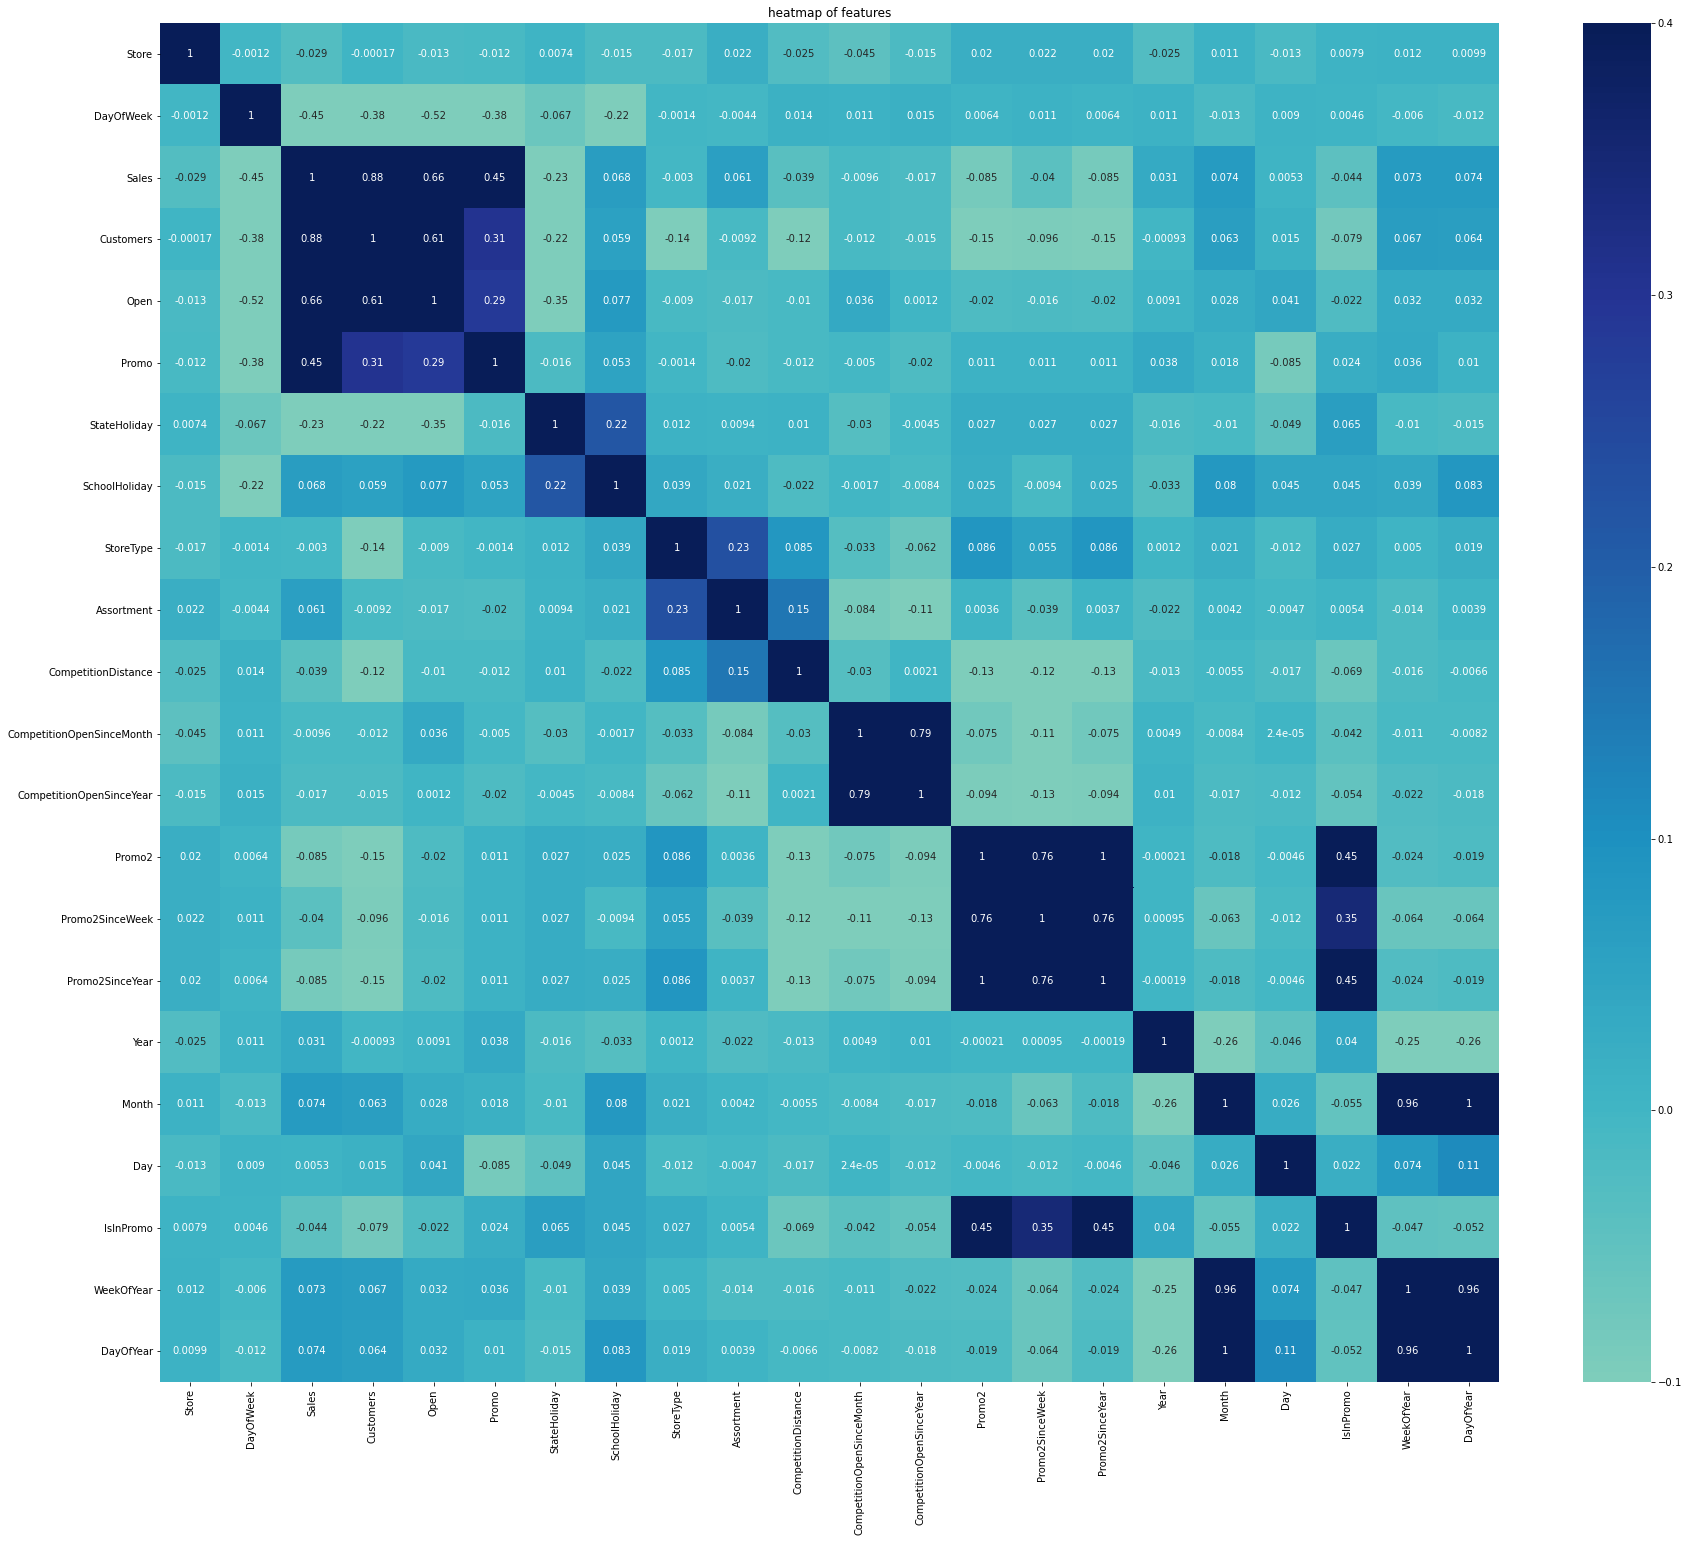

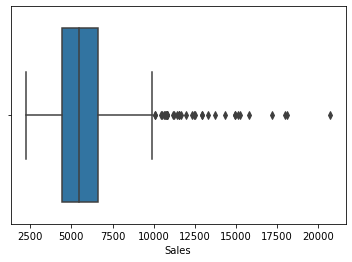

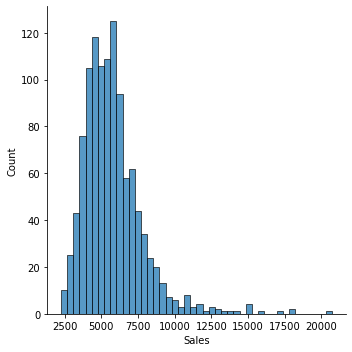

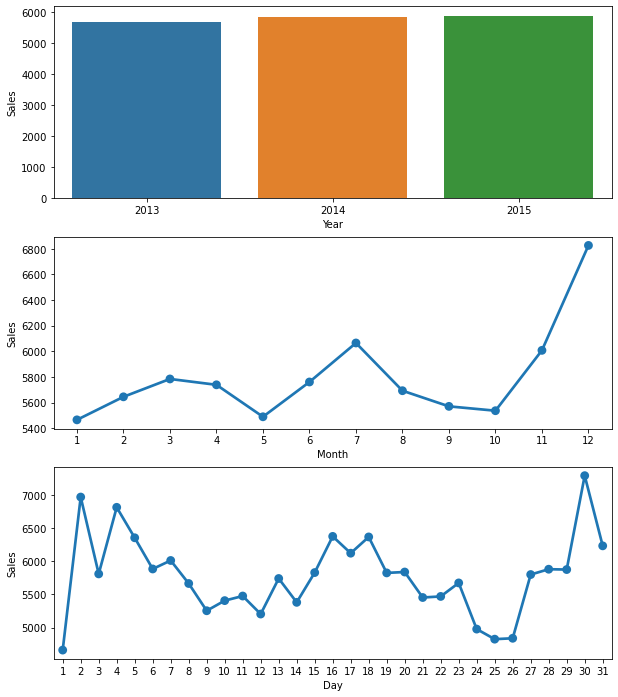

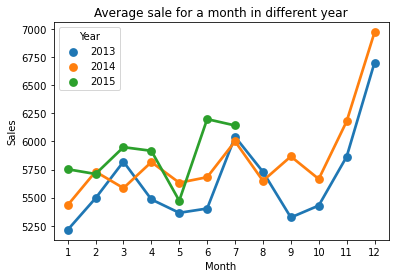

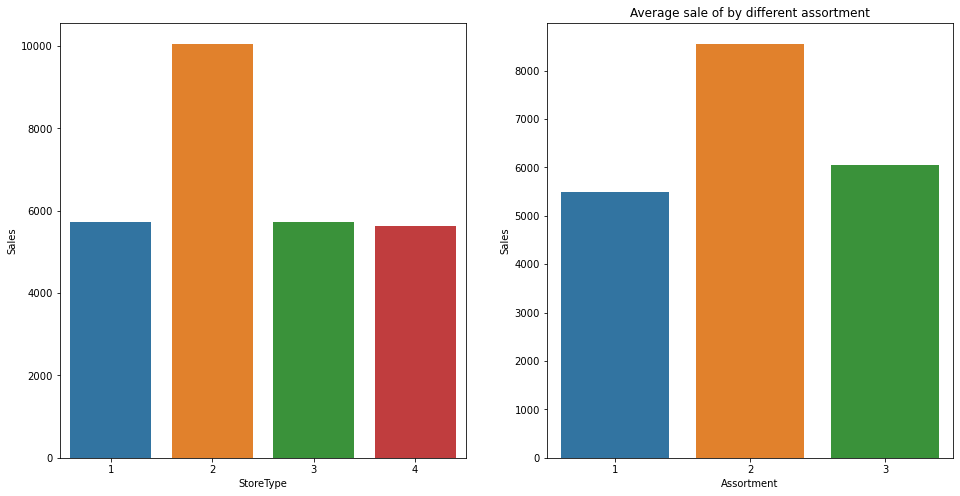

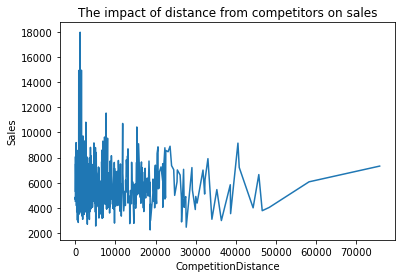

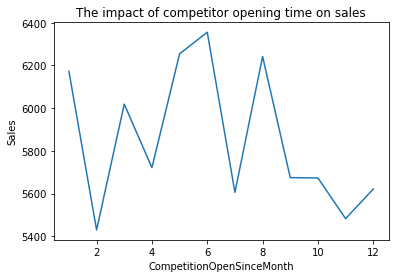

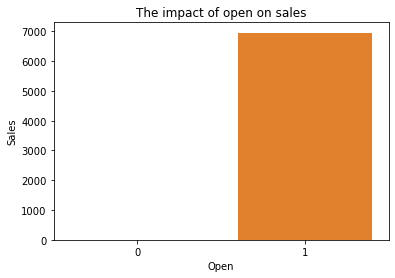

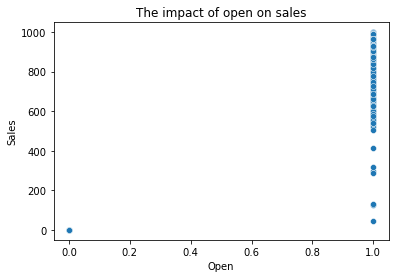

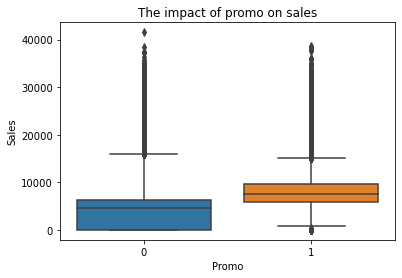

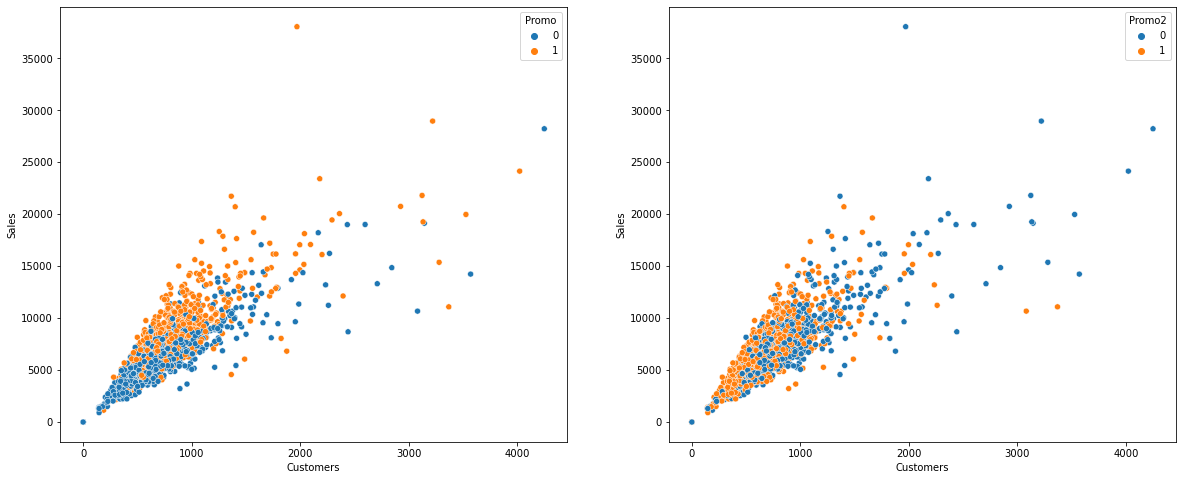

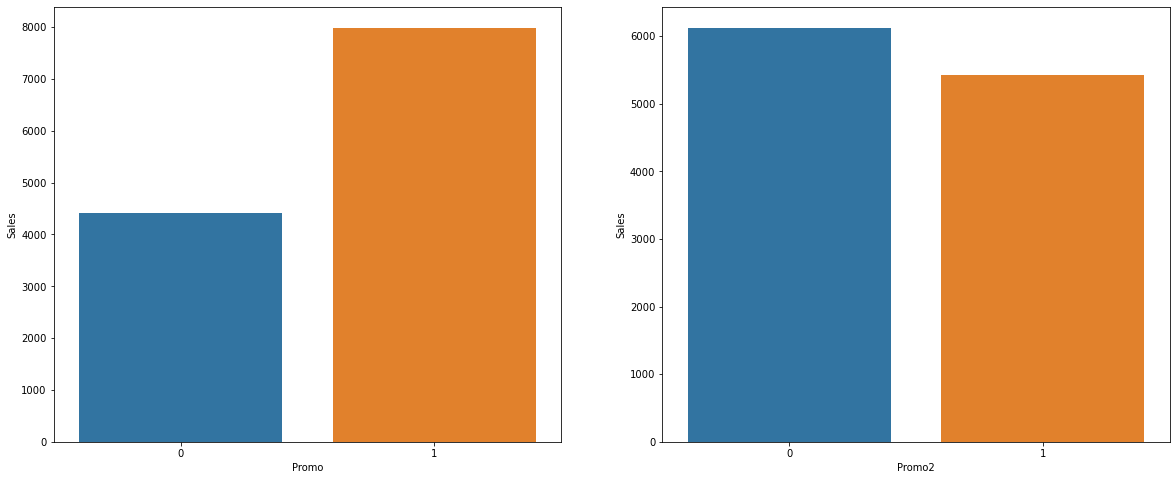

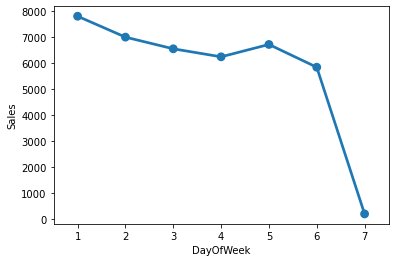

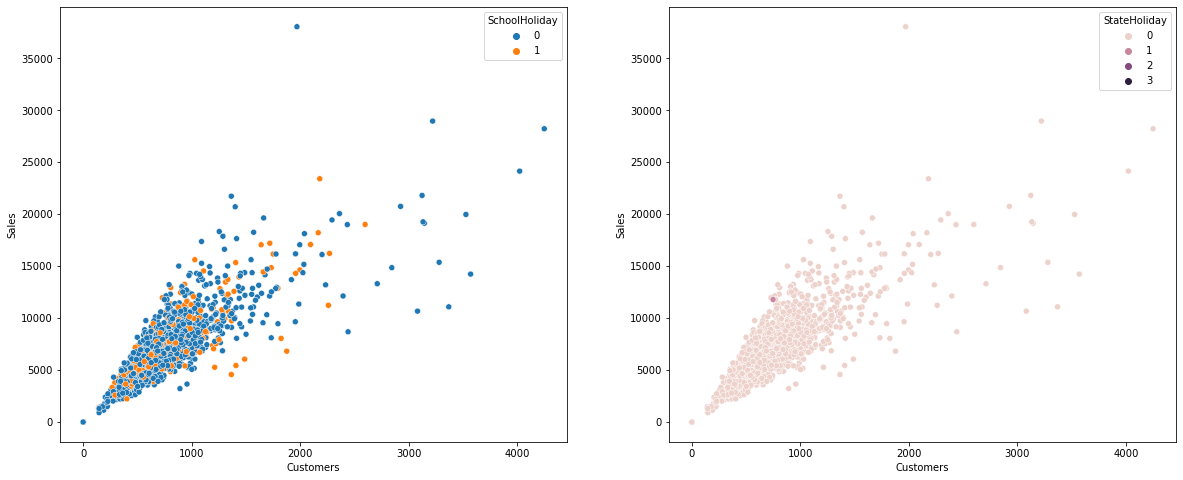

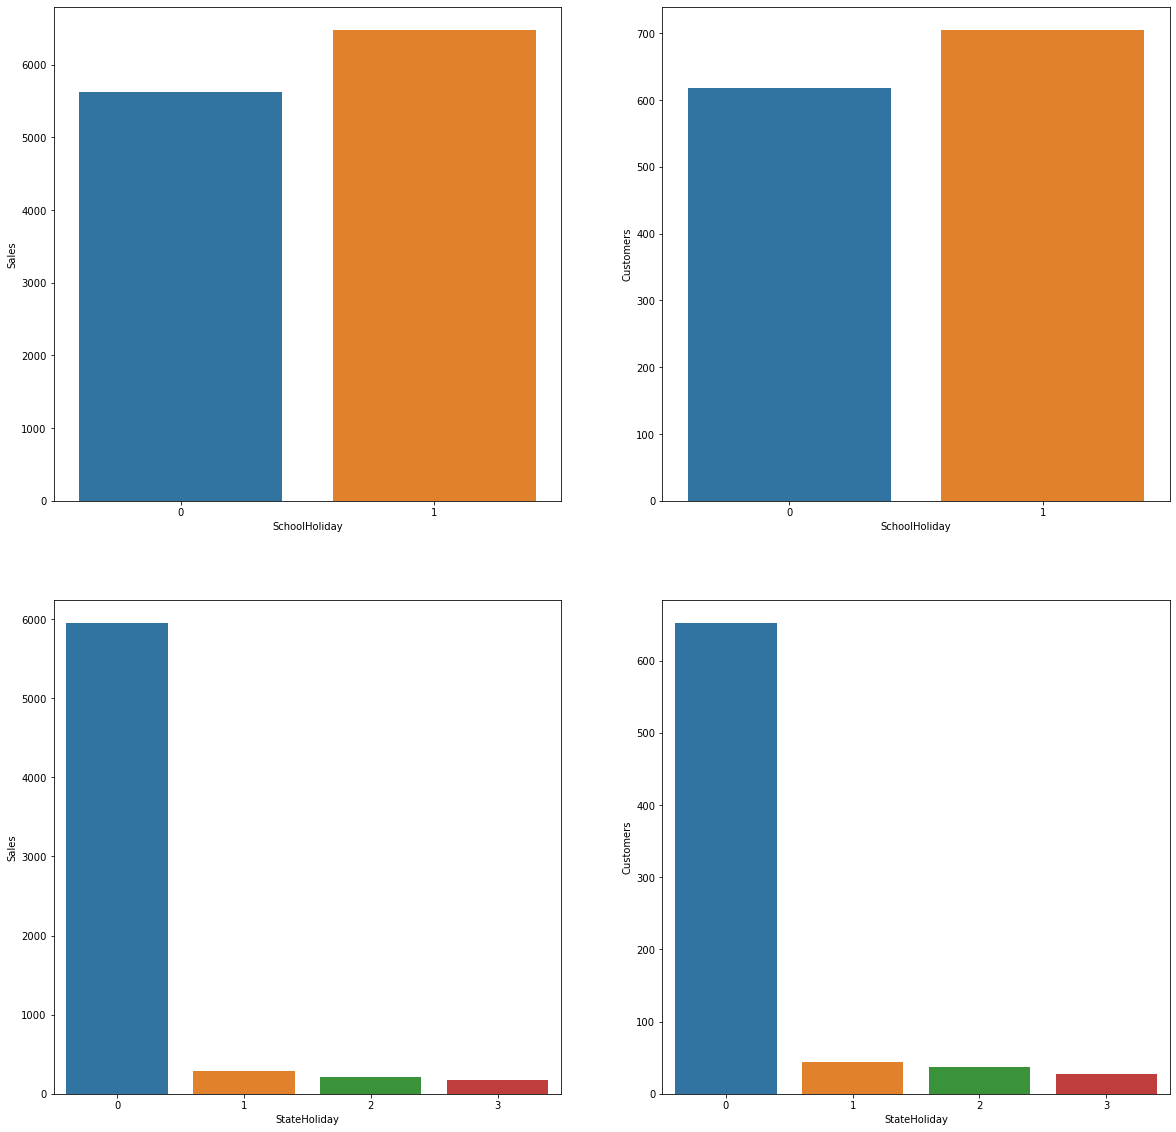

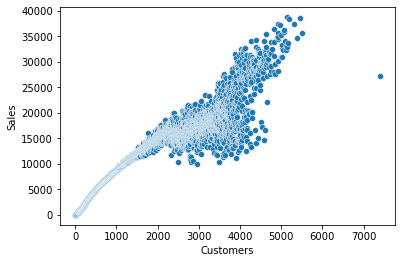

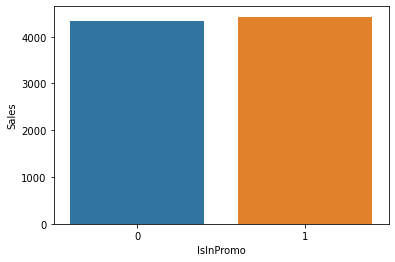

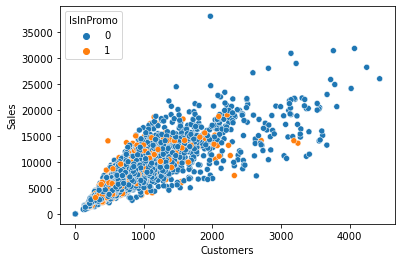

-------------------- plotsGenerating finished --------------------
-------------------- Starting testing xgboost... --------------------
Start training xgboost model...
[0]	train-rmse:7.08588	train-rmspe:0.91088	valid-rmse:7.08396	valid-rmspe:0.91038
[1]	train-rmse:6.66188	train-rmspe:0.91063	valid-rmse:6.65961	valid-rmspe:0.91013
[2]	train-rmse:6.26342	train-rmspe:0.91026	valid-rmse:6.26131	valid-rmspe:0.90976
[3]	train-rmse:5.88898	train-rmspe:0.90974	valid-rmse:5.88648	valid-rmspe:0.90924
[4]	train-rmse:5.53714	train-rmspe:0.90900	valid-rmse:5.53452	valid-rmspe:0.90850
[5]	train-rmse:5.20529	train-rmspe:0.90800	valid-rmse:5.20371	valid-rmspe:0.90750
[6]	train-rmse:4.89428	train-rmspe:0.90667	valid-rmse:4.89267	valid-rmspe:0.90617
[7]	train-rmse:4.60203	train-rmspe:0.90492	valid-rmse:4.60043	valid-rmspe:0.90442
[8]	train-rmse:4.32736	train-rmspe:0.90269	valid-rmse:4.32575	valid-rmspe:0.90219
[9]	train-rmse:4.07474	train-rmspe:0.89994	valid-rmse:4.07295	valid-rmspe:0.89945
[10]	train-

[97]	train-rmse:0.23022	train-rmspe:0.27875	valid-rmse:0.23086	valid-rmspe:0.24562
[98]	train-rmse:0.22965	train-rmspe:0.27880	valid-rmse:0.23026	valid-rmspe:0.24564
[99]	train-rmse:0.22805	train-rmspe:0.27772	valid-rmse:0.22867	valid-rmspe:0.24441
[100]	train-rmse:0.22766	train-rmspe:0.27791	valid-rmse:0.22826	valid-rmspe:0.24451
[101]	train-rmse:0.22744	train-rmspe:0.27822	valid-rmse:0.22804	valid-rmspe:0.24463
[102]	train-rmse:0.22631	train-rmspe:0.27760	valid-rmse:0.22690	valid-rmspe:0.24384
[103]	train-rmse:0.22608	train-rmspe:0.27793	valid-rmse:0.22665	valid-rmspe:0.24401
[104]	train-rmse:0.22571	train-rmspe:0.27798	valid-rmse:0.22625	valid-rmspe:0.24398
[105]	train-rmse:0.22399	train-rmspe:0.27645	valid-rmse:0.22454	valid-rmspe:0.24213
[106]	train-rmse:0.22376	train-rmspe:0.27664	valid-rmse:0.22431	valid-rmspe:0.24224
[107]	train-rmse:0.22337	train-rmspe:0.27648	valid-rmse:0.22393	valid-rmspe:0.24202
[108]	train-rmse:0.22257	train-rmspe:0.27591	valid-rmse:0.22312	valid-rmspe:0.2

[195]	train-rmse:0.16901	train-rmspe:0.22466	valid-rmse:0.17029	valid-rmspe:0.18625
[196]	train-rmse:0.16854	train-rmspe:0.22417	valid-rmse:0.16981	valid-rmspe:0.18574
[197]	train-rmse:0.16807	train-rmspe:0.22352	valid-rmse:0.16935	valid-rmspe:0.18519
[198]	train-rmse:0.16756	train-rmspe:0.22291	valid-rmse:0.16884	valid-rmspe:0.18463
[199]	train-rmse:0.16743	train-rmspe:0.22280	valid-rmse:0.16871	valid-rmspe:0.18447
[200]	train-rmse:0.16675	train-rmspe:0.22191	valid-rmse:0.16805	valid-rmspe:0.18369
[201]	train-rmse:0.16662	train-rmspe:0.22176	valid-rmse:0.16794	valid-rmspe:0.18357
[202]	train-rmse:0.16646	train-rmspe:0.22163	valid-rmse:0.16779	valid-rmspe:0.18341
[203]	train-rmse:0.16609	train-rmspe:0.22130	valid-rmse:0.16741	valid-rmspe:0.18301
[204]	train-rmse:0.16559	train-rmspe:0.22086	valid-rmse:0.16692	valid-rmspe:0.18246
[205]	train-rmse:0.16491	train-rmspe:0.22004	valid-rmse:0.16623	valid-rmspe:0.18170
[206]	train-rmse:0.16447	train-rmspe:0.21952	valid-rmse:0.16581	valid-rmspe:

[293]	train-rmse:0.13585	train-rmspe:0.19336	valid-rmse:0.13777	valid-rmspe:0.15066
[294]	train-rmse:0.13545	train-rmspe:0.19290	valid-rmse:0.13738	valid-rmspe:0.15022
[295]	train-rmse:0.13525	train-rmspe:0.19265	valid-rmse:0.13720	valid-rmspe:0.15000
[296]	train-rmse:0.13503	train-rmspe:0.19249	valid-rmse:0.13699	valid-rmspe:0.14977
[297]	train-rmse:0.13480	train-rmspe:0.19226	valid-rmse:0.13677	valid-rmspe:0.14948
[298]	train-rmse:0.13454	train-rmspe:0.19210	valid-rmse:0.13651	valid-rmspe:0.14920
[299]	train-rmse:0.13426	train-rmspe:0.19187	valid-rmse:0.13623	valid-rmspe:0.14891
[300]	train-rmse:0.13419	train-rmspe:0.19177	valid-rmse:0.13616	valid-rmspe:0.14884
[301]	train-rmse:0.13394	train-rmspe:0.19163	valid-rmse:0.13591	valid-rmspe:0.14858
[302]	train-rmse:0.13369	train-rmspe:0.19143	valid-rmse:0.13567	valid-rmspe:0.14832
[303]	train-rmse:0.13359	train-rmspe:0.19135	valid-rmse:0.13558	valid-rmspe:0.14824
[304]	train-rmse:0.13348	train-rmspe:0.19122	valid-rmse:0.13547	valid-rmspe:

[391]	train-rmse:0.11932	train-rmspe:0.17187	valid-rmse:0.12184	valid-rmspe:0.13343
[392]	train-rmse:0.11923	train-rmspe:0.17184	valid-rmse:0.12176	valid-rmspe:0.13334
[393]	train-rmse:0.11909	train-rmspe:0.17173	valid-rmse:0.12161	valid-rmspe:0.13319
[394]	train-rmse:0.11890	train-rmspe:0.17147	valid-rmse:0.12144	valid-rmspe:0.13300
[395]	train-rmse:0.11875	train-rmspe:0.17132	valid-rmse:0.12129	valid-rmspe:0.13285
[396]	train-rmse:0.11867	train-rmspe:0.17123	valid-rmse:0.12122	valid-rmspe:0.13277
[397]	train-rmse:0.11843	train-rmspe:0.17094	valid-rmse:0.12098	valid-rmspe:0.13244
[398]	train-rmse:0.11834	train-rmspe:0.17087	valid-rmse:0.12090	valid-rmspe:0.13236
[399]	train-rmse:0.11810	train-rmspe:0.17062	valid-rmse:0.12067	valid-rmspe:0.13211
[400]	train-rmse:0.11795	train-rmspe:0.17051	valid-rmse:0.12053	valid-rmspe:0.13198
[401]	train-rmse:0.11776	train-rmspe:0.17037	valid-rmse:0.12034	valid-rmspe:0.13179
[402]	train-rmse:0.11754	train-rmspe:0.17013	valid-rmse:0.12012	valid-rmspe:

[489]	train-rmse:0.10928	train-rmspe:0.15725	valid-rmse:0.11242	valid-rmspe:0.12341
[490]	train-rmse:0.10923	train-rmspe:0.15721	valid-rmse:0.11238	valid-rmspe:0.12337
[491]	train-rmse:0.10918	train-rmspe:0.15717	valid-rmse:0.11234	valid-rmspe:0.12332
[492]	train-rmse:0.10913	train-rmspe:0.15714	valid-rmse:0.11230	valid-rmspe:0.12329
[493]	train-rmse:0.10907	train-rmspe:0.15709	valid-rmse:0.11225	valid-rmspe:0.12323
[494]	train-rmse:0.10897	train-rmspe:0.15699	valid-rmse:0.11217	valid-rmspe:0.12313
[495]	train-rmse:0.10888	train-rmspe:0.15691	valid-rmse:0.11209	valid-rmspe:0.12305
[496]	train-rmse:0.10876	train-rmspe:0.15683	valid-rmse:0.11197	valid-rmspe:0.12294
[497]	train-rmse:0.10871	train-rmspe:0.15679	valid-rmse:0.11193	valid-rmspe:0.12290
[498]	train-rmse:0.10860	train-rmspe:0.15670	valid-rmse:0.11182	valid-rmspe:0.12279
[499]	train-rmse:0.10852	train-rmspe:0.15664	valid-rmse:0.11174	valid-rmspe:0.12272
[500]	train-rmse:0.10849	train-rmspe:0.15662	valid-rmse:0.11171	valid-rmspe:

[587]	train-rmse:0.10236	train-rmspe:0.14477	valid-rmse:0.10608	valid-rmspe:0.11672
[588]	train-rmse:0.10229	train-rmspe:0.14470	valid-rmse:0.10601	valid-rmspe:0.11666
[589]	train-rmse:0.10225	train-rmspe:0.14467	valid-rmse:0.10597	valid-rmspe:0.11663
[590]	train-rmse:0.10221	train-rmspe:0.14464	valid-rmse:0.10594	valid-rmspe:0.11661
[591]	train-rmse:0.10214	train-rmspe:0.14457	valid-rmse:0.10588	valid-rmspe:0.11654
[592]	train-rmse:0.10206	train-rmspe:0.14451	valid-rmse:0.10581	valid-rmspe:0.11645
[593]	train-rmse:0.10203	train-rmspe:0.14449	valid-rmse:0.10579	valid-rmspe:0.11644
[594]	train-rmse:0.10199	train-rmspe:0.14444	valid-rmse:0.10575	valid-rmspe:0.11640
[595]	train-rmse:0.10196	train-rmspe:0.14436	valid-rmse:0.10573	valid-rmspe:0.11636
[596]	train-rmse:0.10194	train-rmspe:0.14434	valid-rmse:0.10572	valid-rmspe:0.11634
[597]	train-rmse:0.10191	train-rmspe:0.14431	valid-rmse:0.10570	valid-rmspe:0.11632
[598]	train-rmse:0.10179	train-rmspe:0.14418	valid-rmse:0.10558	valid-rmspe:

[685]	train-rmse:0.09716	train-rmspe:0.13528	valid-rmse:0.10150	valid-rmspe:0.11209
[686]	train-rmse:0.09711	train-rmspe:0.13519	valid-rmse:0.10146	valid-rmspe:0.11205
[687]	train-rmse:0.09708	train-rmspe:0.13517	valid-rmse:0.10143	valid-rmspe:0.11203
[688]	train-rmse:0.09695	train-rmspe:0.13510	valid-rmse:0.10130	valid-rmspe:0.11190
[689]	train-rmse:0.09690	train-rmspe:0.13507	valid-rmse:0.10125	valid-rmspe:0.11186
[690]	train-rmse:0.09685	train-rmspe:0.13503	valid-rmse:0.10121	valid-rmspe:0.11181
[691]	train-rmse:0.09681	train-rmspe:0.13492	valid-rmse:0.10117	valid-rmspe:0.11176
[692]	train-rmse:0.09669	train-rmspe:0.13480	valid-rmse:0.10106	valid-rmspe:0.11166
[693]	train-rmse:0.09662	train-rmspe:0.13476	valid-rmse:0.10100	valid-rmspe:0.11161
[694]	train-rmse:0.09658	train-rmspe:0.13471	valid-rmse:0.10097	valid-rmspe:0.11157
[695]	train-rmse:0.09652	train-rmspe:0.13464	valid-rmse:0.10091	valid-rmspe:0.11152
[696]	train-rmse:0.09647	train-rmspe:0.13461	valid-rmse:0.10087	valid-rmspe:

[783]	train-rmse:0.09293	train-rmspe:0.13102	valid-rmse:0.09780	valid-rmspe:0.10829
[784]	train-rmse:0.09287	train-rmspe:0.13095	valid-rmse:0.09775	valid-rmspe:0.10820
[785]	train-rmse:0.09276	train-rmspe:0.13079	valid-rmse:0.09765	valid-rmspe:0.10810
[786]	train-rmse:0.09273	train-rmspe:0.13077	valid-rmse:0.09763	valid-rmspe:0.10808
[787]	train-rmse:0.09271	train-rmspe:0.13075	valid-rmse:0.09762	valid-rmspe:0.10807
[788]	train-rmse:0.09268	train-rmspe:0.13073	valid-rmse:0.09760	valid-rmspe:0.10805
[789]	train-rmse:0.09264	train-rmspe:0.13070	valid-rmse:0.09757	valid-rmspe:0.10802
[790]	train-rmse:0.09262	train-rmspe:0.13071	valid-rmse:0.09756	valid-rmspe:0.10801
[791]	train-rmse:0.09260	train-rmspe:0.13070	valid-rmse:0.09754	valid-rmspe:0.10800
[792]	train-rmse:0.09259	train-rmspe:0.13069	valid-rmse:0.09754	valid-rmspe:0.10799
[793]	train-rmse:0.09255	train-rmspe:0.13061	valid-rmse:0.09751	valid-rmspe:0.10794
[794]	train-rmse:0.09250	train-rmspe:0.13056	valid-rmse:0.09747	valid-rmspe:

[881]	train-rmse:0.08993	train-rmspe:0.12605	valid-rmse:0.09540	valid-rmspe:0.10576
[882]	train-rmse:0.08991	train-rmspe:0.12602	valid-rmse:0.09538	valid-rmspe:0.10574
[883]	train-rmse:0.08988	train-rmspe:0.12597	valid-rmse:0.09537	valid-rmspe:0.10572
[884]	train-rmse:0.08983	train-rmspe:0.12593	valid-rmse:0.09533	valid-rmspe:0.10568
[885]	train-rmse:0.08983	train-rmspe:0.12593	valid-rmse:0.09532	valid-rmspe:0.10568
[886]	train-rmse:0.08979	train-rmspe:0.12590	valid-rmse:0.09530	valid-rmspe:0.10565
[887]	train-rmse:0.08978	train-rmspe:0.12589	valid-rmse:0.09529	valid-rmspe:0.10564
[888]	train-rmse:0.08973	train-rmspe:0.12587	valid-rmse:0.09524	valid-rmspe:0.10560
[889]	train-rmse:0.08967	train-rmspe:0.12582	valid-rmse:0.09519	valid-rmspe:0.10555
[890]	train-rmse:0.08965	train-rmspe:0.12579	valid-rmse:0.09518	valid-rmspe:0.10554
[891]	train-rmse:0.08962	train-rmspe:0.12577	valid-rmse:0.09516	valid-rmspe:0.10552
[892]	train-rmse:0.08960	train-rmspe:0.12574	valid-rmse:0.09515	valid-rmspe:

[979]	train-rmse:0.08715	train-rmspe:0.11622	valid-rmse:0.09319	valid-rmspe:0.10352
[980]	train-rmse:0.08714	train-rmspe:0.11619	valid-rmse:0.09319	valid-rmspe:0.10351
[981]	train-rmse:0.08710	train-rmspe:0.11615	valid-rmse:0.09316	valid-rmspe:0.10349
[982]	train-rmse:0.08708	train-rmspe:0.11521	valid-rmse:0.09316	valid-rmspe:0.10348
[983]	train-rmse:0.08704	train-rmspe:0.11518	valid-rmse:0.09312	valid-rmspe:0.10345
[984]	train-rmse:0.08703	train-rmspe:0.11516	valid-rmse:0.09312	valid-rmspe:0.10344
[985]	train-rmse:0.08701	train-rmspe:0.11515	valid-rmse:0.09310	valid-rmspe:0.10343
[986]	train-rmse:0.08700	train-rmspe:0.11513	valid-rmse:0.09309	valid-rmspe:0.10341
[987]	train-rmse:0.08698	train-rmspe:0.11511	valid-rmse:0.09307	valid-rmspe:0.10340
[988]	train-rmse:0.08695	train-rmspe:0.11430	valid-rmse:0.09306	valid-rmspe:0.10337
[989]	train-rmse:0.08693	train-rmspe:0.11428	valid-rmse:0.09305	valid-rmspe:0.10337
[990]	train-rmse:0.08689	train-rmspe:0.11424	valid-rmse:0.09302	valid-rmspe:

[1076]	train-rmse:0.08487	train-rmspe:0.10834	valid-rmse:0.09150	valid-rmspe:0.10173
[1077]	train-rmse:0.08486	train-rmspe:0.10832	valid-rmse:0.09149	valid-rmspe:0.10173
[1078]	train-rmse:0.08485	train-rmspe:0.10827	valid-rmse:0.09148	valid-rmspe:0.10171
[1079]	train-rmse:0.08482	train-rmspe:0.10824	valid-rmse:0.09146	valid-rmspe:0.10169
[1080]	train-rmse:0.08480	train-rmspe:0.10824	valid-rmse:0.09145	valid-rmspe:0.10169
[1081]	train-rmse:0.08479	train-rmspe:0.10823	valid-rmse:0.09144	valid-rmspe:0.10168
[1082]	train-rmse:0.08475	train-rmspe:0.10819	valid-rmse:0.09140	valid-rmspe:0.10164
[1083]	train-rmse:0.08473	train-rmspe:0.10817	valid-rmse:0.09139	valid-rmspe:0.10163
[1084]	train-rmse:0.08472	train-rmspe:0.10816	valid-rmse:0.09139	valid-rmspe:0.10163
[1085]	train-rmse:0.08470	train-rmspe:0.10814	valid-rmse:0.09137	valid-rmspe:0.10161
[1086]	train-rmse:0.08468	train-rmspe:0.10812	valid-rmse:0.09136	valid-rmspe:0.10161
[1087]	train-rmse:0.08467	train-rmspe:0.10811	valid-rmse:0.09135	

[1173]	train-rmse:0.08286	train-rmspe:0.10300	valid-rmse:0.09002	valid-rmspe:0.10034
[1174]	train-rmse:0.08284	train-rmspe:0.10128	valid-rmse:0.09002	valid-rmspe:0.10033
[1175]	train-rmse:0.08282	train-rmspe:0.10126	valid-rmse:0.09001	valid-rmspe:0.10032
[1176]	train-rmse:0.08280	train-rmspe:0.10124	valid-rmse:0.09000	valid-rmspe:0.10031
[1177]	train-rmse:0.08278	train-rmspe:0.10118	valid-rmse:0.09000	valid-rmspe:0.10030
[1178]	train-rmse:0.08275	train-rmspe:0.10115	valid-rmse:0.08997	valid-rmspe:0.10027
[1179]	train-rmse:0.08273	train-rmspe:0.10112	valid-rmse:0.08996	valid-rmspe:0.10027
[1180]	train-rmse:0.08272	train-rmspe:0.10111	valid-rmse:0.08995	valid-rmspe:0.10026
[1181]	train-rmse:0.08271	train-rmspe:0.10110	valid-rmse:0.08994	valid-rmspe:0.10025
[1182]	train-rmse:0.08270	train-rmspe:0.10108	valid-rmse:0.08994	valid-rmspe:0.10024
[1183]	train-rmse:0.08267	train-rmspe:0.10105	valid-rmse:0.08992	valid-rmspe:0.10023
[1184]	train-rmse:0.08266	train-rmspe:0.10104	valid-rmse:0.08991	

[1270]	train-rmse:0.08109	train-rmspe:0.09696	valid-rmse:0.08883	valid-rmspe:0.09907
[1271]	train-rmse:0.08107	train-rmspe:0.09693	valid-rmse:0.08881	valid-rmspe:0.09906
[1272]	train-rmse:0.08106	train-rmspe:0.09693	valid-rmse:0.08881	valid-rmspe:0.09905
[1273]	train-rmse:0.08103	train-rmspe:0.09690	valid-rmse:0.08878	valid-rmspe:0.09904
[1274]	train-rmse:0.08102	train-rmspe:0.09689	valid-rmse:0.08878	valid-rmspe:0.09903
[1275]	train-rmse:0.08101	train-rmspe:0.09687	valid-rmse:0.08877	valid-rmspe:0.09903
[1276]	train-rmse:0.08100	train-rmspe:0.09685	valid-rmse:0.08876	valid-rmspe:0.09902
[1277]	train-rmse:0.08098	train-rmspe:0.09683	valid-rmse:0.08876	valid-rmspe:0.09901
[1278]	train-rmse:0.08096	train-rmspe:0.09681	valid-rmse:0.08874	valid-rmspe:0.09900
[1279]	train-rmse:0.08094	train-rmspe:0.09680	valid-rmse:0.08873	valid-rmspe:0.09899
[1280]	train-rmse:0.08093	train-rmspe:0.09678	valid-rmse:0.08872	valid-rmspe:0.09899
[1281]	train-rmse:0.08088	train-rmspe:0.09674	valid-rmse:0.08868	

[1367]	train-rmse:0.07946	train-rmspe:0.09234	valid-rmse:0.08777	valid-rmspe:0.09813
[1368]	train-rmse:0.07944	train-rmspe:0.09232	valid-rmse:0.08776	valid-rmspe:0.09812
[1369]	train-rmse:0.07943	train-rmspe:0.09228	valid-rmse:0.08776	valid-rmspe:0.09811
[1370]	train-rmse:0.07942	train-rmspe:0.09227	valid-rmse:0.08775	valid-rmspe:0.09811
[1371]	train-rmse:0.07940	train-rmspe:0.09225	valid-rmse:0.08774	valid-rmspe:0.09809
[1372]	train-rmse:0.07938	train-rmspe:0.09223	valid-rmse:0.08772	valid-rmspe:0.09807
[1373]	train-rmse:0.07937	train-rmspe:0.09221	valid-rmse:0.08772	valid-rmspe:0.09806
[1374]	train-rmse:0.07935	train-rmspe:0.09219	valid-rmse:0.08771	valid-rmspe:0.09805
[1375]	train-rmse:0.07935	train-rmspe:0.09218	valid-rmse:0.08770	valid-rmspe:0.09804
[1376]	train-rmse:0.07934	train-rmspe:0.09217	valid-rmse:0.08769	valid-rmspe:0.09804
[1377]	train-rmse:0.07931	train-rmspe:0.09215	valid-rmse:0.08768	valid-rmspe:0.09802
[1378]	train-rmse:0.07930	train-rmspe:0.09213	valid-rmse:0.08766	

[1464]	train-rmse:0.07806	train-rmspe:0.08893	valid-rmse:0.08691	valid-rmspe:0.09721
[1465]	train-rmse:0.07805	train-rmspe:0.08892	valid-rmse:0.08691	valid-rmspe:0.09721
[1466]	train-rmse:0.07804	train-rmspe:0.08890	valid-rmse:0.08690	valid-rmspe:0.09720
[1467]	train-rmse:0.07802	train-rmspe:0.08885	valid-rmse:0.08689	valid-rmspe:0.09718
[1468]	train-rmse:0.07801	train-rmspe:0.08883	valid-rmse:0.08689	valid-rmspe:0.09718
[1469]	train-rmse:0.07800	train-rmspe:0.08882	valid-rmse:0.08688	valid-rmspe:0.09717
[1470]	train-rmse:0.07797	train-rmspe:0.08881	valid-rmse:0.08686	valid-rmspe:0.09716
[1471]	train-rmse:0.07796	train-rmspe:0.08880	valid-rmse:0.08686	valid-rmspe:0.09714
[1472]	train-rmse:0.07795	train-rmspe:0.08878	valid-rmse:0.08684	valid-rmspe:0.09713
[1473]	train-rmse:0.07793	train-rmspe:0.08877	valid-rmse:0.08683	valid-rmspe:0.09713
[1474]	train-rmse:0.07792	train-rmspe:0.08874	valid-rmse:0.08683	valid-rmspe:0.09712
[1475]	train-rmse:0.07790	train-rmspe:0.08870	valid-rmse:0.08683	

[1561]	train-rmse:0.07685	train-rmspe:0.08645	valid-rmse:0.08623	valid-rmspe:0.09654
[1562]	train-rmse:0.07684	train-rmspe:0.08644	valid-rmse:0.08623	valid-rmspe:0.09653
[1563]	train-rmse:0.07683	train-rmspe:0.08643	valid-rmse:0.08622	valid-rmspe:0.09653
[1564]	train-rmse:0.07682	train-rmspe:0.08642	valid-rmse:0.08621	valid-rmspe:0.09652
[1565]	train-rmse:0.07681	train-rmspe:0.08640	valid-rmse:0.08621	valid-rmspe:0.09652
[1566]	train-rmse:0.07680	train-rmspe:0.08638	valid-rmse:0.08621	valid-rmspe:0.09651
[1567]	train-rmse:0.07679	train-rmspe:0.08636	valid-rmse:0.08620	valid-rmspe:0.09651
[1568]	train-rmse:0.07677	train-rmspe:0.08632	valid-rmse:0.08620	valid-rmspe:0.09651
[1569]	train-rmse:0.07675	train-rmspe:0.08630	valid-rmse:0.08618	valid-rmspe:0.09649
[1570]	train-rmse:0.07674	train-rmspe:0.08629	valid-rmse:0.08618	valid-rmspe:0.09649
[1571]	train-rmse:0.07673	train-rmspe:0.08628	valid-rmse:0.08618	valid-rmspe:0.09648
[1572]	train-rmse:0.07671	train-rmspe:0.08626	valid-rmse:0.08616	

[1658]	train-rmse:0.07569	train-rmspe:0.08491	valid-rmse:0.08557	valid-rmspe:0.09573
[1659]	train-rmse:0.07568	train-rmspe:0.08490	valid-rmse:0.08557	valid-rmspe:0.09573
[1660]	train-rmse:0.07567	train-rmspe:0.08490	valid-rmse:0.08557	valid-rmspe:0.09573
[1661]	train-rmse:0.07566	train-rmspe:0.08489	valid-rmse:0.08556	valid-rmspe:0.09572
[1662]	train-rmse:0.07566	train-rmspe:0.08488	valid-rmse:0.08556	valid-rmspe:0.09572
[1663]	train-rmse:0.07564	train-rmspe:0.08486	valid-rmse:0.08555	valid-rmspe:0.09570
[1664]	train-rmse:0.07562	train-rmspe:0.08485	valid-rmse:0.08554	valid-rmspe:0.09570
[1665]	train-rmse:0.07562	train-rmspe:0.08486	valid-rmse:0.08554	valid-rmspe:0.09570
[1666]	train-rmse:0.07561	train-rmspe:0.08485	valid-rmse:0.08553	valid-rmspe:0.09570
[1667]	train-rmse:0.07560	train-rmspe:0.08483	valid-rmse:0.08553	valid-rmspe:0.09569
[1668]	train-rmse:0.07557	train-rmspe:0.08475	valid-rmse:0.08551	valid-rmspe:0.09568
[1669]	train-rmse:0.07556	train-rmspe:0.08474	valid-rmse:0.08550	

[1755]	train-rmse:0.07471	train-rmspe:0.08306	valid-rmse:0.08508	valid-rmspe:0.09526
[1756]	train-rmse:0.07469	train-rmspe:0.08299	valid-rmse:0.08507	valid-rmspe:0.09526
[1757]	train-rmse:0.07468	train-rmspe:0.08297	valid-rmse:0.08507	valid-rmspe:0.09524
[1758]	train-rmse:0.07467	train-rmspe:0.08297	valid-rmse:0.08507	valid-rmspe:0.09525
[1759]	train-rmse:0.07466	train-rmspe:0.08295	valid-rmse:0.08506	valid-rmspe:0.09524
[1760]	train-rmse:0.07465	train-rmspe:0.08294	valid-rmse:0.08506	valid-rmspe:0.09524
[1761]	train-rmse:0.07464	train-rmspe:0.08292	valid-rmse:0.08504	valid-rmspe:0.09523
[1762]	train-rmse:0.07462	train-rmspe:0.08291	valid-rmse:0.08503	valid-rmspe:0.09522
[1763]	train-rmse:0.07461	train-rmspe:0.08289	valid-rmse:0.08503	valid-rmspe:0.09520
[1764]	train-rmse:0.07459	train-rmspe:0.08288	valid-rmse:0.08502	valid-rmspe:0.09519
[1765]	train-rmse:0.07459	train-rmspe:0.08287	valid-rmse:0.08502	valid-rmspe:0.09519
[1766]	train-rmse:0.07457	train-rmspe:0.08284	valid-rmse:0.08501	

[1852]	train-rmse:0.07371	train-rmspe:0.08132	valid-rmse:0.08458	valid-rmspe:0.09477
[1853]	train-rmse:0.07370	train-rmspe:0.08108	valid-rmse:0.08457	valid-rmspe:0.09477
[1854]	train-rmse:0.07368	train-rmspe:0.08107	valid-rmse:0.08457	valid-rmspe:0.09476
[1855]	train-rmse:0.07367	train-rmspe:0.08106	valid-rmse:0.08456	valid-rmspe:0.09476
[1856]	train-rmse:0.07366	train-rmspe:0.08105	valid-rmse:0.08456	valid-rmspe:0.09476
[1857]	train-rmse:0.07366	train-rmspe:0.08105	valid-rmse:0.08456	valid-rmspe:0.09475
[1858]	train-rmse:0.07365	train-rmspe:0.08103	valid-rmse:0.08455	valid-rmspe:0.09475
[1859]	train-rmse:0.07364	train-rmspe:0.08102	valid-rmse:0.08454	valid-rmspe:0.09474
[1860]	train-rmse:0.07363	train-rmspe:0.08101	valid-rmse:0.08454	valid-rmspe:0.09473
[1861]	train-rmse:0.07362	train-rmspe:0.08100	valid-rmse:0.08453	valid-rmspe:0.09473
[1862]	train-rmse:0.07361	train-rmspe:0.08099	valid-rmse:0.08452	valid-rmspe:0.09472
[1863]	train-rmse:0.07360	train-rmspe:0.08098	valid-rmse:0.08452	

[1949]	train-rmse:0.07275	train-rmspe:0.07951	valid-rmse:0.08409	valid-rmspe:0.09431
[1950]	train-rmse:0.07274	train-rmspe:0.07950	valid-rmse:0.08409	valid-rmspe:0.09430
[1951]	train-rmse:0.07272	train-rmspe:0.07948	valid-rmse:0.08408	valid-rmspe:0.09428
[1952]	train-rmse:0.07272	train-rmspe:0.07948	valid-rmse:0.08408	valid-rmspe:0.09428
[1953]	train-rmse:0.07271	train-rmspe:0.07947	valid-rmse:0.08407	valid-rmspe:0.09428
[1954]	train-rmse:0.07270	train-rmspe:0.07946	valid-rmse:0.08407	valid-rmspe:0.09428
[1955]	train-rmse:0.07269	train-rmspe:0.07946	valid-rmse:0.08407	valid-rmspe:0.09428
[1956]	train-rmse:0.07267	train-rmspe:0.07944	valid-rmse:0.08405	valid-rmspe:0.09427
[1957]	train-rmse:0.07266	train-rmspe:0.07943	valid-rmse:0.08404	valid-rmspe:0.09426
[1958]	train-rmse:0.07265	train-rmspe:0.07942	valid-rmse:0.08404	valid-rmspe:0.09426
[1959]	train-rmse:0.07265	train-rmspe:0.07941	valid-rmse:0.08404	valid-rmspe:0.09426
[1960]	train-rmse:0.07264	train-rmspe:0.07941	valid-rmse:0.08403	

[2046]	train-rmse:0.07183	train-rmspe:0.07777	valid-rmse:0.08369	valid-rmspe:0.09395
[2047]	train-rmse:0.07182	train-rmspe:0.07776	valid-rmse:0.08369	valid-rmspe:0.09395
[2048]	train-rmse:0.07182	train-rmspe:0.07776	valid-rmse:0.08368	valid-rmspe:0.09395
[2049]	train-rmse:0.07180	train-rmspe:0.07774	valid-rmse:0.08367	valid-rmspe:0.09394
[2050]	train-rmse:0.07180	train-rmspe:0.07774	valid-rmse:0.08367	valid-rmspe:0.09393
[2051]	train-rmse:0.07178	train-rmspe:0.07772	valid-rmse:0.08366	valid-rmspe:0.09392
[2052]	train-rmse:0.07176	train-rmspe:0.07769	valid-rmse:0.08365	valid-rmspe:0.09391
[2053]	train-rmse:0.07176	train-rmspe:0.07769	valid-rmse:0.08365	valid-rmspe:0.09391
[2054]	train-rmse:0.07175	train-rmspe:0.07768	valid-rmse:0.08365	valid-rmspe:0.09391
[2055]	train-rmse:0.07174	train-rmspe:0.07767	valid-rmse:0.08364	valid-rmspe:0.09390
[2056]	train-rmse:0.07173	train-rmspe:0.07764	valid-rmse:0.08364	valid-rmspe:0.09388
[2057]	train-rmse:0.07170	train-rmspe:0.07759	valid-rmse:0.08363	

[2143]	train-rmse:0.07094	train-rmspe:0.07632	valid-rmse:0.08328	valid-rmspe:0.09351
[2144]	train-rmse:0.07093	train-rmspe:0.07631	valid-rmse:0.08328	valid-rmspe:0.09350
[2145]	train-rmse:0.07092	train-rmspe:0.07631	valid-rmse:0.08327	valid-rmspe:0.09350
[2146]	train-rmse:0.07092	train-rmspe:0.07630	valid-rmse:0.08327	valid-rmspe:0.09350
[2147]	train-rmse:0.07091	train-rmspe:0.07629	valid-rmse:0.08327	valid-rmspe:0.09349
[2148]	train-rmse:0.07090	train-rmspe:0.07628	valid-rmse:0.08326	valid-rmspe:0.09349
[2149]	train-rmse:0.07089	train-rmspe:0.07627	valid-rmse:0.08325	valid-rmspe:0.09348
[2150]	train-rmse:0.07088	train-rmspe:0.07625	valid-rmse:0.08325	valid-rmspe:0.09348
[2151]	train-rmse:0.07087	train-rmspe:0.07624	valid-rmse:0.08325	valid-rmspe:0.09348
[2152]	train-rmse:0.07086	train-rmspe:0.07623	valid-rmse:0.08324	valid-rmspe:0.09347
[2153]	train-rmse:0.07086	train-rmspe:0.07622	valid-rmse:0.08324	valid-rmspe:0.09347
[2154]	train-rmse:0.07085	train-rmspe:0.07621	valid-rmse:0.08323	

[2240]	train-rmse:0.07015	train-rmspe:0.07524	valid-rmse:0.08295	valid-rmspe:0.09321
[2241]	train-rmse:0.07014	train-rmspe:0.07523	valid-rmse:0.08294	valid-rmspe:0.09321
[2242]	train-rmse:0.07014	train-rmspe:0.07522	valid-rmse:0.08294	valid-rmspe:0.09320
[2243]	train-rmse:0.07013	train-rmspe:0.07521	valid-rmse:0.08294	valid-rmspe:0.09320
[2244]	train-rmse:0.07011	train-rmspe:0.07519	valid-rmse:0.08294	valid-rmspe:0.09321
[2245]	train-rmse:0.07011	train-rmspe:0.07518	valid-rmse:0.08294	valid-rmspe:0.09320
[2246]	train-rmse:0.07010	train-rmspe:0.07517	valid-rmse:0.08294	valid-rmspe:0.09321
[2247]	train-rmse:0.07009	train-rmspe:0.07516	valid-rmse:0.08293	valid-rmspe:0.09320
[2248]	train-rmse:0.07008	train-rmspe:0.07515	valid-rmse:0.08293	valid-rmspe:0.09319
[2249]	train-rmse:0.07008	train-rmspe:0.07515	valid-rmse:0.08293	valid-rmspe:0.09319
[2250]	train-rmse:0.07007	train-rmspe:0.07512	valid-rmse:0.08292	valid-rmspe:0.09319
[2251]	train-rmse:0.07006	train-rmspe:0.07511	valid-rmse:0.08292	

[2337]	train-rmse:0.06939	train-rmspe:0.07416	valid-rmse:0.08266	valid-rmspe:0.09286
[2338]	train-rmse:0.06939	train-rmspe:0.07415	valid-rmse:0.08266	valid-rmspe:0.09287
[2339]	train-rmse:0.06938	train-rmspe:0.07414	valid-rmse:0.08265	valid-rmspe:0.09286
[2340]	train-rmse:0.06937	train-rmspe:0.07414	valid-rmse:0.08265	valid-rmspe:0.09285
[2341]	train-rmse:0.06937	train-rmspe:0.07413	valid-rmse:0.08264	valid-rmspe:0.09285
[2342]	train-rmse:0.06935	train-rmspe:0.07411	valid-rmse:0.08264	valid-rmspe:0.09285
[2343]	train-rmse:0.06935	train-rmspe:0.07411	valid-rmse:0.08264	valid-rmspe:0.09285
[2344]	train-rmse:0.06935	train-rmspe:0.07410	valid-rmse:0.08264	valid-rmspe:0.09285
[2345]	train-rmse:0.06934	train-rmspe:0.07410	valid-rmse:0.08264	valid-rmspe:0.09284
[2346]	train-rmse:0.06934	train-rmspe:0.07410	valid-rmse:0.08264	valid-rmspe:0.09284
[2347]	train-rmse:0.06933	train-rmspe:0.07408	valid-rmse:0.08263	valid-rmspe:0.09284
[2348]	train-rmse:0.06932	train-rmspe:0.07407	valid-rmse:0.08264	

[2434]	train-rmse:0.06865	train-rmspe:0.07315	valid-rmse:0.08238	valid-rmspe:0.09263
[2435]	train-rmse:0.06865	train-rmspe:0.07315	valid-rmse:0.08238	valid-rmspe:0.09263
[2436]	train-rmse:0.06864	train-rmspe:0.07313	valid-rmse:0.08238	valid-rmspe:0.09263
[2437]	train-rmse:0.06863	train-rmspe:0.07312	valid-rmse:0.08238	valid-rmspe:0.09263
[2438]	train-rmse:0.06863	train-rmspe:0.07311	valid-rmse:0.08237	valid-rmspe:0.09263
[2439]	train-rmse:0.06862	train-rmspe:0.07311	valid-rmse:0.08237	valid-rmspe:0.09263
[2440]	train-rmse:0.06861	train-rmspe:0.07310	valid-rmse:0.08237	valid-rmspe:0.09262
[2441]	train-rmse:0.06860	train-rmspe:0.07309	valid-rmse:0.08236	valid-rmspe:0.09262
[2442]	train-rmse:0.06860	train-rmspe:0.07309	valid-rmse:0.08236	valid-rmspe:0.09262
[2443]	train-rmse:0.06859	train-rmspe:0.07308	valid-rmse:0.08236	valid-rmspe:0.09261
[2444]	train-rmse:0.06859	train-rmspe:0.07307	valid-rmse:0.08236	valid-rmspe:0.09261
[2445]	train-rmse:0.06858	train-rmspe:0.07306	valid-rmse:0.08235	

[2531]	train-rmse:0.06799	train-rmspe:0.07218	valid-rmse:0.08217	valid-rmspe:0.09244
[2532]	train-rmse:0.06798	train-rmspe:0.07217	valid-rmse:0.08217	valid-rmspe:0.09243
[2533]	train-rmse:0.06798	train-rmspe:0.07216	valid-rmse:0.08216	valid-rmspe:0.09243
[2534]	train-rmse:0.06797	train-rmspe:0.07215	valid-rmse:0.08216	valid-rmspe:0.09244
[2535]	train-rmse:0.06797	train-rmspe:0.07215	valid-rmse:0.08216	valid-rmspe:0.09243
[2536]	train-rmse:0.06796	train-rmspe:0.07215	valid-rmse:0.08216	valid-rmspe:0.09243
[2537]	train-rmse:0.06795	train-rmspe:0.07214	valid-rmse:0.08216	valid-rmspe:0.09243
[2538]	train-rmse:0.06795	train-rmspe:0.07213	valid-rmse:0.08215	valid-rmspe:0.09242
[2539]	train-rmse:0.06794	train-rmspe:0.07213	valid-rmse:0.08215	valid-rmspe:0.09242
[2540]	train-rmse:0.06793	train-rmspe:0.07211	valid-rmse:0.08215	valid-rmspe:0.09242
[2541]	train-rmse:0.06793	train-rmspe:0.07211	valid-rmse:0.08215	valid-rmspe:0.09242
[2542]	train-rmse:0.06792	train-rmspe:0.07210	valid-rmse:0.08215	

[2628]	train-rmse:0.06737	train-rmspe:0.07141	valid-rmse:0.08196	valid-rmspe:0.09219
[2629]	train-rmse:0.06736	train-rmspe:0.07140	valid-rmse:0.08196	valid-rmspe:0.09219
[2630]	train-rmse:0.06736	train-rmspe:0.07140	valid-rmse:0.08196	valid-rmspe:0.09219
[2631]	train-rmse:0.06735	train-rmspe:0.07139	valid-rmse:0.08195	valid-rmspe:0.09219
[2632]	train-rmse:0.06734	train-rmspe:0.07138	valid-rmse:0.08195	valid-rmspe:0.09218
[2633]	train-rmse:0.06734	train-rmspe:0.07137	valid-rmse:0.08195	valid-rmspe:0.09218
[2634]	train-rmse:0.06733	train-rmspe:0.07137	valid-rmse:0.08195	valid-rmspe:0.09218
[2635]	train-rmse:0.06733	train-rmspe:0.07137	valid-rmse:0.08194	valid-rmspe:0.09218
[2636]	train-rmse:0.06732	train-rmspe:0.07136	valid-rmse:0.08195	valid-rmspe:0.09218
[2637]	train-rmse:0.06732	train-rmspe:0.07128	valid-rmse:0.08194	valid-rmspe:0.09218
[2638]	train-rmse:0.06731	train-rmspe:0.07127	valid-rmse:0.08194	valid-rmspe:0.09217
[2639]	train-rmse:0.06731	train-rmspe:0.07126	valid-rmse:0.08194	

[2725]	train-rmse:0.06676	train-rmspe:0.07047	valid-rmse:0.08178	valid-rmspe:0.09196
[2726]	train-rmse:0.06675	train-rmspe:0.07046	valid-rmse:0.08178	valid-rmspe:0.09196
[2727]	train-rmse:0.06675	train-rmspe:0.07046	valid-rmse:0.08177	valid-rmspe:0.09195
[2728]	train-rmse:0.06674	train-rmspe:0.07045	valid-rmse:0.08177	valid-rmspe:0.09195
[2729]	train-rmse:0.06674	train-rmspe:0.07044	valid-rmse:0.08177	valid-rmspe:0.09195
[2730]	train-rmse:0.06673	train-rmspe:0.07043	valid-rmse:0.08177	valid-rmspe:0.09195
[2731]	train-rmse:0.06673	train-rmspe:0.07042	valid-rmse:0.08177	valid-rmspe:0.09196
[2732]	train-rmse:0.06672	train-rmspe:0.07042	valid-rmse:0.08177	valid-rmspe:0.09195
[2733]	train-rmse:0.06671	train-rmspe:0.07041	valid-rmse:0.08177	valid-rmspe:0.09195
[2734]	train-rmse:0.06671	train-rmspe:0.07040	valid-rmse:0.08177	valid-rmspe:0.09195
[2735]	train-rmse:0.06670	train-rmspe:0.07040	valid-rmse:0.08177	valid-rmspe:0.09194
[2736]	train-rmse:0.06669	train-rmspe:0.07039	valid-rmse:0.08176	

[2822]	train-rmse:0.06618	train-rmspe:0.06969	valid-rmse:0.08161	valid-rmspe:0.09178
[2823]	train-rmse:0.06617	train-rmspe:0.06969	valid-rmse:0.08161	valid-rmspe:0.09178
[2824]	train-rmse:0.06617	train-rmspe:0.06968	valid-rmse:0.08161	valid-rmspe:0.09177
[2825]	train-rmse:0.06617	train-rmspe:0.06968	valid-rmse:0.08160	valid-rmspe:0.09177
[2826]	train-rmse:0.06616	train-rmspe:0.06967	valid-rmse:0.08160	valid-rmspe:0.09176
[2827]	train-rmse:0.06615	train-rmspe:0.06966	valid-rmse:0.08160	valid-rmspe:0.09176
[2828]	train-rmse:0.06615	train-rmspe:0.06966	valid-rmse:0.08160	valid-rmspe:0.09176
[2829]	train-rmse:0.06614	train-rmspe:0.06964	valid-rmse:0.08160	valid-rmspe:0.09175
[2830]	train-rmse:0.06613	train-rmspe:0.06964	valid-rmse:0.08159	valid-rmspe:0.09174
[2831]	train-rmse:0.06612	train-rmspe:0.06962	valid-rmse:0.08159	valid-rmspe:0.09173
[2832]	train-rmse:0.06612	train-rmspe:0.06961	valid-rmse:0.08159	valid-rmspe:0.09173
[2833]	train-rmse:0.06611	train-rmspe:0.06961	valid-rmse:0.08159	

[2919]	train-rmse:0.06560	train-rmspe:0.06896	valid-rmse:0.08143	valid-rmspe:0.09157
[2920]	train-rmse:0.06560	train-rmspe:0.06893	valid-rmse:0.08143	valid-rmspe:0.09157
[2921]	train-rmse:0.06559	train-rmspe:0.06892	valid-rmse:0.08143	valid-rmspe:0.09157
[2922]	train-rmse:0.06559	train-rmspe:0.06891	valid-rmse:0.08143	valid-rmspe:0.09157
[2923]	train-rmse:0.06558	train-rmspe:0.06891	valid-rmse:0.08143	valid-rmspe:0.09157
[2924]	train-rmse:0.06557	train-rmspe:0.06890	valid-rmse:0.08143	valid-rmspe:0.09157
[2925]	train-rmse:0.06557	train-rmspe:0.06889	valid-rmse:0.08143	valid-rmspe:0.09157
[2926]	train-rmse:0.06556	train-rmspe:0.06889	valid-rmse:0.08143	valid-rmspe:0.09157
[2927]	train-rmse:0.06556	train-rmspe:0.06888	valid-rmse:0.08143	valid-rmspe:0.09156
[2928]	train-rmse:0.06555	train-rmspe:0.06887	valid-rmse:0.08142	valid-rmspe:0.09156
[2929]	train-rmse:0.06555	train-rmspe:0.06887	valid-rmse:0.08142	valid-rmspe:0.09156
[2930]	train-rmse:0.06554	train-rmspe:0.06886	valid-rmse:0.08142	

[3016]	train-rmse:0.06508	train-rmspe:0.06823	valid-rmse:0.08130	valid-rmspe:0.09144
[3017]	train-rmse:0.06507	train-rmspe:0.06822	valid-rmse:0.08130	valid-rmspe:0.09143
[3018]	train-rmse:0.06507	train-rmspe:0.06821	valid-rmse:0.08130	valid-rmspe:0.09143
[3019]	train-rmse:0.06506	train-rmspe:0.06820	valid-rmse:0.08130	valid-rmspe:0.09142
[3020]	train-rmse:0.06505	train-rmspe:0.06819	valid-rmse:0.08130	valid-rmspe:0.09142
[3021]	train-rmse:0.06505	train-rmspe:0.06818	valid-rmse:0.08130	valid-rmspe:0.09142
[3022]	train-rmse:0.06504	train-rmspe:0.06818	valid-rmse:0.08130	valid-rmspe:0.09142
[3023]	train-rmse:0.06504	train-rmspe:0.06817	valid-rmse:0.08130	valid-rmspe:0.09142
[3024]	train-rmse:0.06503	train-rmspe:0.06817	valid-rmse:0.08129	valid-rmspe:0.09141
[3025]	train-rmse:0.06503	train-rmspe:0.06816	valid-rmse:0.08129	valid-rmspe:0.09141
[3026]	train-rmse:0.06502	train-rmspe:0.06815	valid-rmse:0.08129	valid-rmspe:0.09141
[3027]	train-rmse:0.06502	train-rmspe:0.06815	valid-rmse:0.08129	

[3113]	train-rmse:0.06457	train-rmspe:0.06760	valid-rmse:0.08117	valid-rmspe:0.09123
[3114]	train-rmse:0.06456	train-rmspe:0.06759	valid-rmse:0.08117	valid-rmspe:0.09123
[3115]	train-rmse:0.06456	train-rmspe:0.06759	valid-rmse:0.08117	valid-rmspe:0.09123
[3116]	train-rmse:0.06455	train-rmspe:0.06758	valid-rmse:0.08116	valid-rmspe:0.09123
[3117]	train-rmse:0.06455	train-rmspe:0.06757	valid-rmse:0.08116	valid-rmspe:0.09123
[3118]	train-rmse:0.06454	train-rmspe:0.06756	valid-rmse:0.08116	valid-rmspe:0.09123
[3119]	train-rmse:0.06453	train-rmspe:0.06756	valid-rmse:0.08116	valid-rmspe:0.09123
[3120]	train-rmse:0.06453	train-rmspe:0.06755	valid-rmse:0.08116	valid-rmspe:0.09123
[3121]	train-rmse:0.06453	train-rmspe:0.06755	valid-rmse:0.08116	valid-rmspe:0.09122
[3122]	train-rmse:0.06452	train-rmspe:0.06754	valid-rmse:0.08115	valid-rmspe:0.09122
[3123]	train-rmse:0.06452	train-rmspe:0.06753	valid-rmse:0.08115	valid-rmspe:0.09122
[3124]	train-rmse:0.06451	train-rmspe:0.06752	valid-rmse:0.08115	

[3210]	train-rmse:0.06406	train-rmspe:0.06689	valid-rmse:0.08104	valid-rmspe:0.09111
[3211]	train-rmse:0.06405	train-rmspe:0.06688	valid-rmse:0.08104	valid-rmspe:0.09111
[3212]	train-rmse:0.06404	train-rmspe:0.06687	valid-rmse:0.08103	valid-rmspe:0.09111
[3213]	train-rmse:0.06404	train-rmspe:0.06686	valid-rmse:0.08103	valid-rmspe:0.09112
[3214]	train-rmse:0.06403	train-rmspe:0.06686	valid-rmse:0.08103	valid-rmspe:0.09112
[3215]	train-rmse:0.06403	train-rmspe:0.06685	valid-rmse:0.08103	valid-rmspe:0.09112
[3216]	train-rmse:0.06402	train-rmspe:0.06685	valid-rmse:0.08103	valid-rmspe:0.09112
[3217]	train-rmse:0.06402	train-rmspe:0.06684	valid-rmse:0.08103	valid-rmspe:0.09112
[3218]	train-rmse:0.06401	train-rmspe:0.06682	valid-rmse:0.08103	valid-rmspe:0.09112
[3219]	train-rmse:0.06401	train-rmspe:0.06682	valid-rmse:0.08103	valid-rmspe:0.09113
[3220]	train-rmse:0.06400	train-rmspe:0.06681	valid-rmse:0.08103	valid-rmspe:0.09112
[3221]	train-rmse:0.06400	train-rmspe:0.06681	valid-rmse:0.08103	

[3307]	train-rmse:0.06357	train-rmspe:0.06627	valid-rmse:0.08094	valid-rmspe:0.09104
[3308]	train-rmse:0.06357	train-rmspe:0.06626	valid-rmse:0.08094	valid-rmspe:0.09104
[3309]	train-rmse:0.06356	train-rmspe:0.06625	valid-rmse:0.08094	valid-rmspe:0.09104
[3310]	train-rmse:0.06356	train-rmspe:0.06625	valid-rmse:0.08093	valid-rmspe:0.09104
[3311]	train-rmse:0.06355	train-rmspe:0.06624	valid-rmse:0.08093	valid-rmspe:0.09104
[3312]	train-rmse:0.06355	train-rmspe:0.06624	valid-rmse:0.08093	valid-rmspe:0.09103
[3313]	train-rmse:0.06354	train-rmspe:0.06623	valid-rmse:0.08093	valid-rmspe:0.09102
[3314]	train-rmse:0.06354	train-rmspe:0.06622	valid-rmse:0.08092	valid-rmspe:0.09102
[3315]	train-rmse:0.06353	train-rmspe:0.06622	valid-rmse:0.08093	valid-rmspe:0.09102
[3316]	train-rmse:0.06352	train-rmspe:0.06620	valid-rmse:0.08093	valid-rmspe:0.09102
[3317]	train-rmse:0.06352	train-rmspe:0.06620	valid-rmse:0.08092	valid-rmspe:0.09102
[3318]	train-rmse:0.06352	train-rmspe:0.06620	valid-rmse:0.08092	

[3404]	train-rmse:0.06307	train-rmspe:0.06561	valid-rmse:0.08084	valid-rmspe:0.09086
[3405]	train-rmse:0.06306	train-rmspe:0.06560	valid-rmse:0.08083	valid-rmspe:0.09085
[3406]	train-rmse:0.06306	train-rmspe:0.06559	valid-rmse:0.08084	valid-rmspe:0.09088
[3407]	train-rmse:0.06305	train-rmspe:0.06559	valid-rmse:0.08084	valid-rmspe:0.09088
[3408]	train-rmse:0.06305	train-rmspe:0.06558	valid-rmse:0.08084	valid-rmspe:0.09088
[3409]	train-rmse:0.06304	train-rmspe:0.06557	valid-rmse:0.08084	valid-rmspe:0.09087
[3410]	train-rmse:0.06304	train-rmspe:0.06556	valid-rmse:0.08084	valid-rmspe:0.09087
[3411]	train-rmse:0.06303	train-rmspe:0.06555	valid-rmse:0.08083	valid-rmspe:0.09087
[3412]	train-rmse:0.06303	train-rmspe:0.06554	valid-rmse:0.08084	valid-rmspe:0.09089
[3413]	train-rmse:0.06303	train-rmspe:0.06554	valid-rmse:0.08084	valid-rmspe:0.09089
[3414]	train-rmse:0.06302	train-rmspe:0.06553	valid-rmse:0.08084	valid-rmspe:0.09089
[3415]	train-rmse:0.06302	train-rmspe:0.06553	valid-rmse:0.08084	

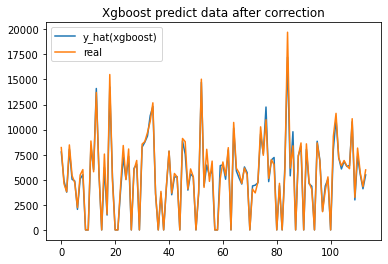

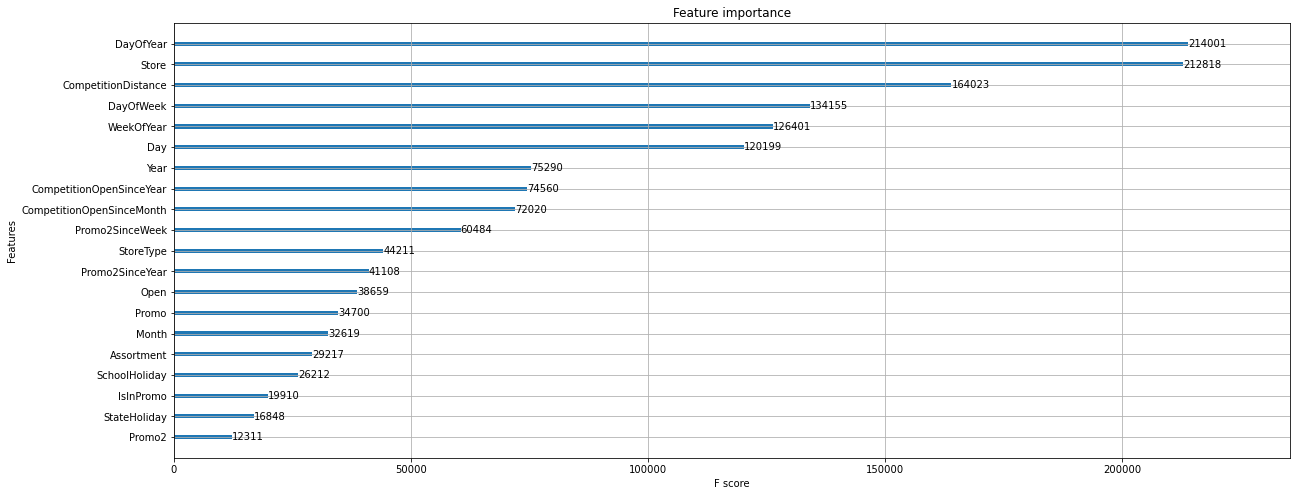

plots generation is finished...

Start generating submission.csv ...
submission.csv generation is finished...

-------------------- xgboost test is finished --------------------


In [17]:
if __name__ == '__main__':
    main()